---
#Descripción de la actividad
---

Limpieza, análisis, visualización y agrupamiento.
En esta base de datos encontraras:

* Aguas subterraneas.
* Aguas superficiales.

Por lo que realizaras el mismo análisis en ambas bases de datos:

* Limpieza de base de datos.
* Explorar  cada datos (auxiliate de describe(), mean(), plot, boxplot de pandas):
* Identificando tendencias centrales promedio, media y mediana de los datos. 
* Identificar medidas de dispersión, máximo, mínimo .
* Identificar medidas de posición no centrales , los cuartiles , outliers.   
* Identificar correlaciones.
* Preparar los datos 
* Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.
* Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México.


 

---
##**Librerias requeridas**
---

In [ ]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes #Instalar siempre para poder utilizar geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point
# activate plot theme
import qeds
qeds.themes.mpl_style();
from sklearn.cluster import KMeans
from pandas.core.internals.concat import concat_arrays
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns  
import sys

---
##**Conjunto de datos**

* Tenemos 4 Datasets, los cuales contienen información relacionada a la calidad del agua de acuerdo a monitoreos realizados en aguas subterraneas y superficiales, adicionalmente contamos con sus respectivas escalas. 
* Se revisará la información general de cada conjunto de datos para determinar si es necesario realizar transformaciones que permitan trabajar de una mejor manera con ellos. 

---

Almacenaremos en variables las respectivas rutas de los datasets con el fin de evitar estar subiendo los archivos a Colab cada que volvamos a ingresar. 

In [ ]:
db_aguas_subterraneas  = 'https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-equipo-64/main/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv'
db_aguas_superficiales = 'https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-equipo-64/main/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv'
db_escala_subterranea  = 'https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-equipo-64/main/Datos_de_calidad_del_agua_2020/Escalas_subterranea.csv'
db_escala_superficial  = 'https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-equipo-64/main/Datos_de_calidad_del_agua_2020/Escalas_superficial.csv'

---
#**Base 1 - Aguas subterraneas**
---

---
##**Ejercicio 1. Limpieza de la base de datos**

---

In [ ]:
df1 = pd.read_csv(db_aguas_subterraneas,encoding='cp1252')
dfsub= df1.copy()
dfsub.head(5)

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CALIDAD_ALC,CONDUCT_mS/cm,CALIDAD_CONDUC,SDT_mg/L,SDT_M_mg/L,CALIDAD_SDT_ra,CALIDAD_SDT_salin,FLUORUROS_mg/L,CALIDAD_FLUO,DUR_mg/L,CALIDAD_DUR,COLI_FEC_NMP/100_mL,CALIDAD_COLI_FEC,N_NO3_mg/L,CALIDAD_N_NO3,AS_TOT_mg/L,CALIDAD_AS,CD_TOT_mg/L,CALIDAD_CD,CR_TOT_mg/L,CALIDAD_CR,HG_TOT_mg/L,CALIDAD_HG,PB_TOT_mg/L,CALIDAD_PB,MN_TOT_mg/L,CALIDAD_MN,FE_TOT_mg/L,CALIDAD_FE,SEMAFORO,CONTAMINANTES,CUMPLE_CON_ALC,CUMPLE_CON_COND,CUMPLE_CON_SDT_ra,CUMPLE_CON_SDT_salin,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,Alta,940.0,Permisible para riego,NaN,603.6,Cultivos sensibles,Potable - Dulce,0.9766,Potable - Optima,213.732,Potable - Dura,<1.1,Potable - Excelente,4.184656,Potable - Excelente,0.0161,Apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,0.0891,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,Alta,608.0,Buena para riego,NaN,445.4,Excelente para riego,Potable - Dulce,0.9298,Potable - Optima,185.0514,Potable - Dura,<1.1,Potable - Excelente,5.75011,Potable - Buena calidad,0.0134,Apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,Alta,532.0,Buena para riego,NaN,342,Excelente para riego,Potable - Dulce,1.8045,Alta,120.719,Potable - Dura,<1.1,Potable - Excelente,1.449803,Potable - Excelente,0.037,No apta como FAAP,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Rojo,"FLUO,AS,",SI,SI,SI,SI,NO,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,Alta,686.0,Buena para riego,NaN,478.6,Excelente para riego,Potable - Dulce,1.1229,Potable - Optima,199.879,Potable - Dura,<1.1,Potable - Excelente,1.258597,Potable - Excelente,0.0154,Apta como FAAP,<0.003,Potable - Excelente,0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Verde,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,Alta,1841.0,Permisible para riego,NaN,1179,Cultivos con manejo especial,Ligeramente salobres,0.2343,Baja,476.9872,Potable - Dura,291,Aceptable,15.672251,No apta como FAAP,<0.01,Potable - Excelente,<0.003,Potable - Excelente,<0.005,Potable - Excelente,<0.0005,Potable - Excelente,<0.005,Potable - Excelente,<0.0015,Potable - Excelente,<0.025,Potable - Excelente,Rojo,"NO3,",SI,SI,SI,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


---
Calculamos el tamaño de nuestra base de datos

---

In [ ]:
dfsub.shape

(1068, 57)

---
Con el metodo info consultamos la información general de los datos 

---

In [ ]:
dfsub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

---
* Revisando el dataset y los tipos de variables iniciales, es necesario realizar modificaciones para cambiar de tipo, pero de acuerdo a la base de datos compartida no tenemos información de los tipos de dato, así que realizando una exploración de las 5 primeras columnas pudimos observar que tipo de información se tiene y de ese modo asignarle el tipo de dato más adecuado, que nos permita realizar un apropiado analisis y los respectivos pipelines en caso de que sea requerido para desarrollar algun modelo de aprendizaje automatico.
* Revisamos si tenemos valores nulos
---

In [ ]:
dfsub.isna().any()

CLAVE                   False
SITIO                   False
ORGANISMO_DE_CUENCA     False
ESTADO                  False
MUNICIPIO               False
ACUIFERO                False
SUBTIPO                 False
LONGITUD                False
LATITUD                 False
PERIODO                 False
ALC_mg/L                 True
CALIDAD_ALC              True
CONDUCT_mS/cm            True
CALIDAD_CONDUC           True
SDT_mg/L                 True
SDT_M_mg/L               True
CALIDAD_SDT_ra           True
CALIDAD_SDT_salin        True
FLUORUROS_mg/L          False
CALIDAD_FLUO            False
DUR_mg/L                 True
CALIDAD_DUR              True
COLI_FEC_NMP/100_mL     False
CALIDAD_COLI_FEC        False
N_NO3_mg/L               True
CALIDAD_N_NO3            True
AS_TOT_mg/L             False
CALIDAD_AS              False
CD_TOT_mg/L             False
CALIDAD_CD              False
CR_TOT_mg/L             False
CALIDAD_CR              False
HG_TOT_mg/L             False
CALIDAD_HG

---
A continuación se modifican los tipos de variables de acuerdo a los hallazgos correspondientes. Pero primero se debe reemplazar los valores en unas variables que son de tipo numerico pero aparecen con datos del estilo < 1.1 lo cual al transformace a numero va a generar error de tipo si quisieramos hacer alguna operación matematica con ellos. 

---

In [ ]:
dfsub['FLUORUROS_mg/L'].replace({'<0.2':0.199}, inplace = True)
dfsub['COLI_FEC_NMP/100_mL'].replace({'<1.1':1}, inplace = True)
dfsub['AS_TOT_mg/L'].replace({'<0.01':0.0099}, inplace = True)
dfsub['CD_TOT_mg/L'].replace({'<0.003':0.00299}, inplace = True)
dfsub['CR_TOT_mg/L'].replace({'<0.005':0.00499}, inplace = True)
dfsub['MN_TOT_mg/L'].replace({'<0.0015':0.001499}, inplace = True)
dfsub['HG_TOT_mg/L'].replace({'<0.0005':0.000499}, inplace = True)
dfsub['PB_TOT_mg/L'].replace({'<0.005':0.00499}, inplace = True)
dfsub['FE_TOT_mg/L'].replace({'<0.025':0.02499}, inplace = True)
dfsub['DUR_mg/L'].replace({'<20':19.99}, inplace = True)
dfsub['AS_TOT_mg/L'].replace({'<0.02':0.0199}, inplace = True)
dfsub['SDT_M_mg/L'].replace({'<25':24.99}, inplace = True)
dfsub['N_NO3_mg/L'].replace({'<0.02':0.0199}, inplace = True)

In [ ]:
dfsub = dfsub.astype({'CLAVE'               : 'object',  #Objeto                 
                      'SITIO'               : 'object',  #Objeto                  
                      'ORGANISMO_DE_CUENCA' : 'object',  #Objeto       
                      'ESTADO'              : 'object',  #Objeto                   
                      'MUNICIPIO'           : 'object',  #Objeto  
                      'ACUIFERO'            : 'object',  #Objeto                  
                      'SUBTIPO'             : 'category',#Categorico
                      'LONGITUD'            : 'float64', #float
                      'LATITUD'             : 'float64', #float
                      'PERIODO'            : 'int64',   #Int
                      'ALC_mg/L'            : 'float64', #float
                      'CALIDAD_ALC'         : 'category',#Categorico
                      'CONDUCT_mS/cm'       : 'float64', #float
                      'CALIDAD_CONDUC'      : 'category',#Categorico
                      'SDT_mg/L'            : 'float64', #float
                      'CALIDAD_SDT_ra'      : 'category',#Categorico
                      'CALIDAD_SDT_salin'   : 'category',#Categorico
                      'CALIDAD_FLUO'        : 'category',#Categorico              
                      'CALIDAD_DUR'         : 'category',#Categorico
                      'CALIDAD_COLI_FEC'    : 'category',#Categorico           
                      'CALIDAD_N_NO3'       : 'category',#Categorico
                      'CALIDAD_AS'          : 'category',#Categorico
                      'CALIDAD_CD'          : 'category',#Categorico
                      'CALIDAD_CR'          : 'category',#Categorico             
                      'CALIDAD_HG'          : 'category',#Categorico
                      'CALIDAD_PB'          : 'category',#Categorico
                      'CALIDAD_MN'          : 'category',#Categorico
                      'CALIDAD_FE'          : 'category',#Categorico
                      'SEMAFORO'            : 'category',#Categorico
                      'CONTAMINANTES'       : 'object',  #Objeto 
                      'CUMPLE_CON_ALC'      : 'category',#Categorico
                      'CUMPLE_CON_COND'     : 'category',#Categorico
                      'CUMPLE_CON_SDT_ra'   : 'category',#Categorico
                      'CUMPLE_CON_SDT_salin': 'category',#Categorico
                      'CUMPLE_CON_FLUO'     : 'category',#Categorico
                      'CUMPLE_CON_DUR'      : 'category',#Categorico
                      'CUMPLE_CON_CF'       : 'category',#Categorico
                      'CUMPLE_CON_NO3'      : 'category',#Categorico
                      'CUMPLE_CON_AS'       : 'category',#Categorico
                      'CUMPLE_CON_CD'       : 'category',#Categorico
                      'CUMPLE_CON_CR'       : 'category',#Categorico
                      'CUMPLE_CON_HG'       : 'category',#Categorico
                      'CUMPLE_CON_PB'       : 'category',#Categorico
                      'CUMPLE_CON_MN'       : 'category',#Categorico
                      'CUMPLE_CON_FE'       : 'category',#Categorico
                      'FLUORUROS_mg/L'      : 'float64', #float
                      'COLI_FEC_NMP/100_mL' : 'float64', #float
                      'AS_TOT_mg/L'         : 'float64', #float
                      'CD_TOT_mg/L'         : 'float64', #float
                      'CR_TOT_mg/L'         : 'float64', #float
                      'MN_TOT_mg/L'         : 'float64', #float
                      'FE_TOT_mg/L'         : 'float64', #float
                      'HG_TOT_mg/L'         : 'float64', #float
                      'SDT_M_mg/L'          : 'float64', #float
                      'DUR_mg/L'            : 'float64', #float
                      'N_NO3_mg/L'          : 'float64', #float
                      'PB_TOT_mg/L'          :'float64', #float
                      })

In [ ]:
dfsub['ALC_mg/L'].fillna(value = dfsub['ALC_mg/L'].mean(), inplace = True)
dfsub['CALIDAD_ALC'].fillna(value = "Media", inplace = True)
dfsub['CONDUCT_mS/cm'].fillna(value = dfsub['CONDUCT_mS/cm'].mean(), inplace = True)
dfsub['CALIDAD_CONDUC'].fillna(value = dfsub['CALIDAD_CONDUC'].mode()[0], inplace = True)
dfsub['SDT_mg/L'].fillna(value = 0, inplace = True)
dfsub['SDT_M_mg/L'].fillna(value = 0, inplace = True)
dfsub['CALIDAD_SDT_ra'].fillna(value = dfsub['CALIDAD_SDT_ra'].mode()[0], inplace = True)
dfsub['CALIDAD_SDT_salin'].fillna(value = dfsub['CALIDAD_SDT_salin'].mode()[0], inplace = True)
dfsub['DUR_mg/L'].fillna(value = dfsub['DUR_mg/L'].mean(), inplace = True)
dfsub['CALIDAD_DUR'].fillna(value = dfsub['CALIDAD_DUR'].mode()[0], inplace = True)
dfsub['N_NO3_mg/L'].fillna(value = dfsub['N_NO3_mg/L'].mean(), inplace = True)
dfsub['CALIDAD_N_NO3'].fillna(value = dfsub['CALIDAD_N_NO3'].mode()[0], inplace = True)

In [ ]:
dfsub.isna().any()

CLAVE                   False
SITIO                   False
ORGANISMO_DE_CUENCA     False
ESTADO                  False
MUNICIPIO               False
ACUIFERO                False
SUBTIPO                 False
LONGITUD                False
LATITUD                 False
PERIODO                 False
ALC_mg/L                False
CALIDAD_ALC             False
CONDUCT_mS/cm           False
CALIDAD_CONDUC          False
SDT_mg/L                False
SDT_M_mg/L              False
CALIDAD_SDT_ra          False
CALIDAD_SDT_salin       False
FLUORUROS_mg/L          False
CALIDAD_FLUO            False
DUR_mg/L                False
CALIDAD_DUR             False
COLI_FEC_NMP/100_mL     False
CALIDAD_COLI_FEC        False
N_NO3_mg/L              False
CALIDAD_N_NO3           False
AS_TOT_mg/L             False
CALIDAD_AS              False
CD_TOT_mg/L             False
CALIDAD_CD              False
CR_TOT_mg/L             False
CALIDAD_CR              False
HG_TOT_mg/L             False
CALIDAD_HG

In [ ]:
dfsub.dtypes

CLAVE                     object
SITIO                     object
ORGANISMO_DE_CUENCA       object
ESTADO                    object
MUNICIPIO                 object
ACUIFERO                  object
SUBTIPO                 category
LONGITUD                 float64
LATITUD                  float64
PERIODO                    int64
ALC_mg/L                 float64
CALIDAD_ALC             category
CONDUCT_mS/cm            float64
CALIDAD_CONDUC          category
SDT_mg/L                 float64
SDT_M_mg/L               float64
CALIDAD_SDT_ra          category
CALIDAD_SDT_salin       category
FLUORUROS_mg/L           float64
CALIDAD_FLUO            category
DUR_mg/L                 float64
CALIDAD_DUR             category
COLI_FEC_NMP/100_mL      float64
CALIDAD_COLI_FEC        category
N_NO3_mg/L               float64
CALIDAD_N_NO3           category
AS_TOT_mg/L              float64
CALIDAD_AS              category
CD_TOT_mg/L              float64
CALIDAD_CD              category
CR_TOT_mg/

---
Realizaremos separación de las variables (features) en:

* Numerica (quantitative)
* Categórica (categorical)
* ordinal 

---

In [ ]:
quantitative_features = ['LONGITUD', 'LATITUD', 'PERIODO', 'ALC_mg/L','CONDUCT_mS/cm', 'SDT_mg/L','SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL','N_NO3_mg/L', 'AS_TOT_mg/L','CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L','FE_TOT_mg/L']

categorical_features =  ['SUBTIPO', 'CALIDAD_ALC', 'CALIDAD_CONDUC','CALIDAD_SDT_ra','CALIDAD_SDT_salin','CALIDAD_FLUO','CALIDAD_DUR','CALIDAD_COLI_FEC', 'CALIDAD_N_NO3','CALIDAD_AS','CALIDAD_CD','CALIDAD_CR','CALIDAD_HG','CALIDAD_PB','CALIDAD_MN','CALIDAD_FE', 'SEMAFORO','CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra',
                         'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR','CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD','CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN','CUMPLE_CON_FE']

ordinal_features = ['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO','ACUIFERO', 'CONTAMINANTES']

---
se propone reaizar las siguientes imputaciones:

Cuantitativas: Se propone realizar una sustitución por la media, ya que al ser un valor continuo, es una forma de disminuir el impacto de esta variable en nuestras métricas estadísticas.

Categóricas: Se propone realizar una sustitución por la moda, ya que al ser una variable categórica y sustituir por el valor más común, por 'probabilidad', es el valor que tienen más oportunidad de estar en ese dato faltante.

Ordinales: Se propone realizar una sustitución por la moda, ya que al ser una variable similar a la categórica, hace sentido que el manejo sea el mismo.

Para realizar este proceso vamos a usar las clases 
**```SimpleImputer, ColumnTransformer, StandardScaler, OneHotEncoder, Pipeline```**, el caso de las variables cuantitativas lo vamos a abordar en el paso siguiente.

---

In [ ]:
ordinal_transformer = Pipeline(
    [('imputer_ordinal', SimpleImputer(strategy='median'))]
)

---
Para hacer el análisis de las variables cuantitativas, a diferencia de lo que las variables categóricas, no existe una forma obvia de agrupar los datos, por tal motivo lo que se suele hacer es, dividir los posibles valores en diferentes contenedores(bins) del mismo tamaño y luego contar el número de casos que cae dentro de cada uno de los contenedores. Estos contenedores junto con sus recuentos, nos proporcionan una imagen de la distribución de la variable cuantitativa y constituyen la base para poder graficar el histograma.

---

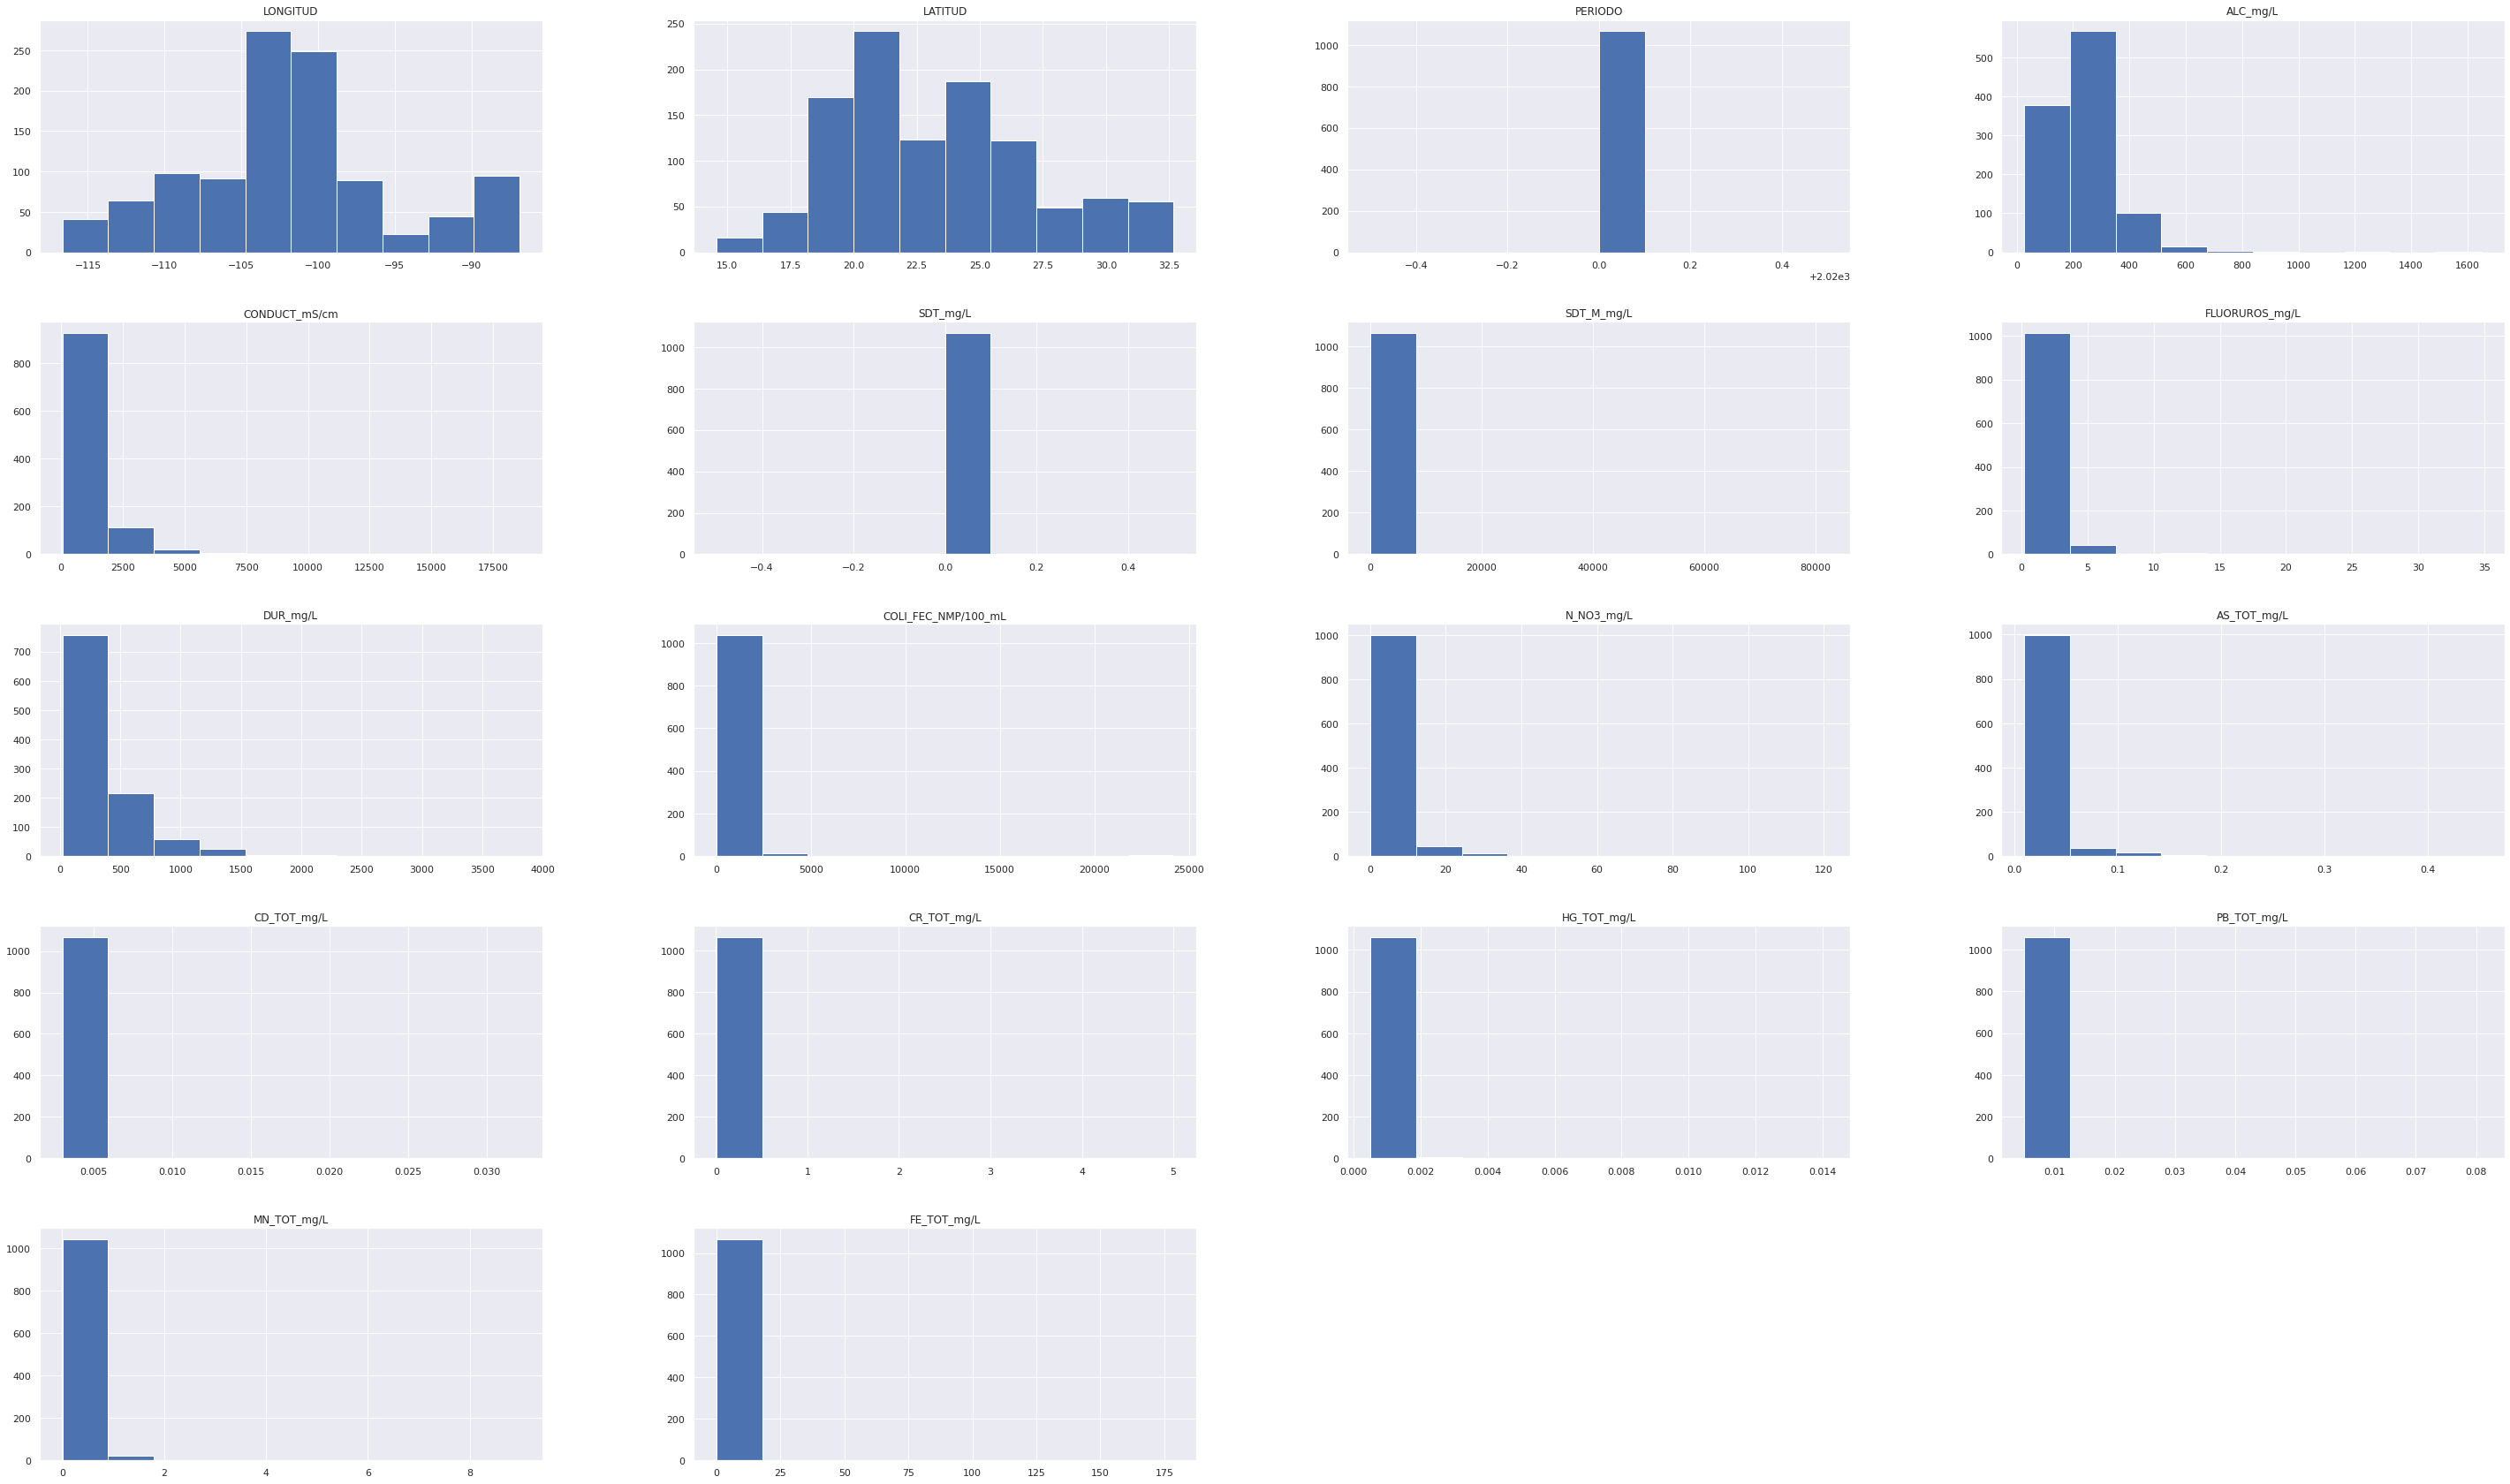

In [ ]:
sns.set(rc={'figure.figsize':(50,30)})

df_numeric = dfsub[quantitative_features].copy()
df_numeric.hist(bins=10)

plt.show()

---
Como las columnas son diferentes en escala, las vamos a estandarizar para tener una escala común al construir el modelo de aprendizaje automático utilizando **```StandardScaler()```**.

---

In [ ]:
quantitative_transformer = Pipeline(
    steps=[("imputer_quantitative", SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]
)

---
Para nuestras variables de tipo categorico aplicaremos la transformación **```OneHotEncoder```** la cual permite que nuestros datos categoricos sean mas expresivos. Debido que muchos modelos de aprendizaje automatico requieren trabajar con datos numericos.

---

In [ ]:
categorical_transformer = Pipeline(
    [('imputer_categorical', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown = 'ignore'))]
)

---
Se crea el objeto Pre-procesador (Instancia de ColumnTransformer) que se utilizará más adelante como parte del Pipeline. ColumnTransformer toma una lista, que contiene tuplas de las transformaciones que deseamos realizar en las diferentes columnas. **(Esto será utilizado para la segunda parte del reto)**

---


In [ ]:
preprocessor = ColumnTransformer(
        transformers = [
            ('ordinal_transformer', ordinal_transformer, ordinal_features),
            ('quantitative_transformer', quantitative_transformer, quantitative_features),
            ('categorical_transformer', categorical_transformer, categorical_features)
        ],
    remainder='passthrough' #Todas las columnas restantes que no se especificaron transformers se pasarán automáticamente
)

---
## **Ejercicio 2. Exploración de los datos**

Primero vamos a observar nuestras métricas estadisticas generales.

---

In [ ]:
dfsub.describe()

,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CONDUCT_mS/cm,SDT_mg/L,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
count,1068.000000,1068.000000,1068.0,1068.000000,1068.000000,1068.0,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,-101.891007,23.163618,2020.0,235.633759,1138.953013,0.0,894.423465,1.075448,347.937829,355.421348,4.319753,0.019542,0.003020,0.013268,0.000556,0.005272,0.072478,0.410384
std,6.703263,3.887670,0.0,116.655014,1242.056683,0.0,2749.223872,1.924348,359.501093,2052.468941,8.341225,0.035230,0.000895,0.154392,0.000467,0.003255,0.376513,5.537974
min,-116.664250,14.561150,2020.0,26.640000,50.400000,0.0,0.000000,0.199000,19.990000,1.000000,0.019900,0.009900,0.002990,0.004990,0.000499,0.004990,0.001499,0.024990
25%,-105.388865,20.212055,2020.0,164.048750,505.500000,0.0,337.383325,0.267175,121.274100,1.000000,0.650932,0.009900,0.002990,0.004990,0.000499,0.004990,0.001499,0.024990
50%,-102.174180,22.617190,2020.0,215.825000,822.500000,0.0,548.600000,0.503500,245.662350,1.000000,2.082916,0.009900,0.002990,0.004990,0.000499,0.004990,0.001499,0.046960
75%,-98.974716,25.510285,2020.0,292.423750,1321.250000,0.0,915.900000,1.139850,453.930000,13.250000,5.200047,0.009900,0.002990,0.004990,0.000499,0.004990,0.009947,0.173380
max,-86.864120,32.677713,2020.0,1650.000000,18577.000000,0.0,82170.000000,34.803300,3810.692200,24196.000000,121.007813,0.452200,0.032110,5.003200,0.014150,0.080900,8.982000,178.615000


---
Ahora observaremos la correlación entre nuestras variables.

---

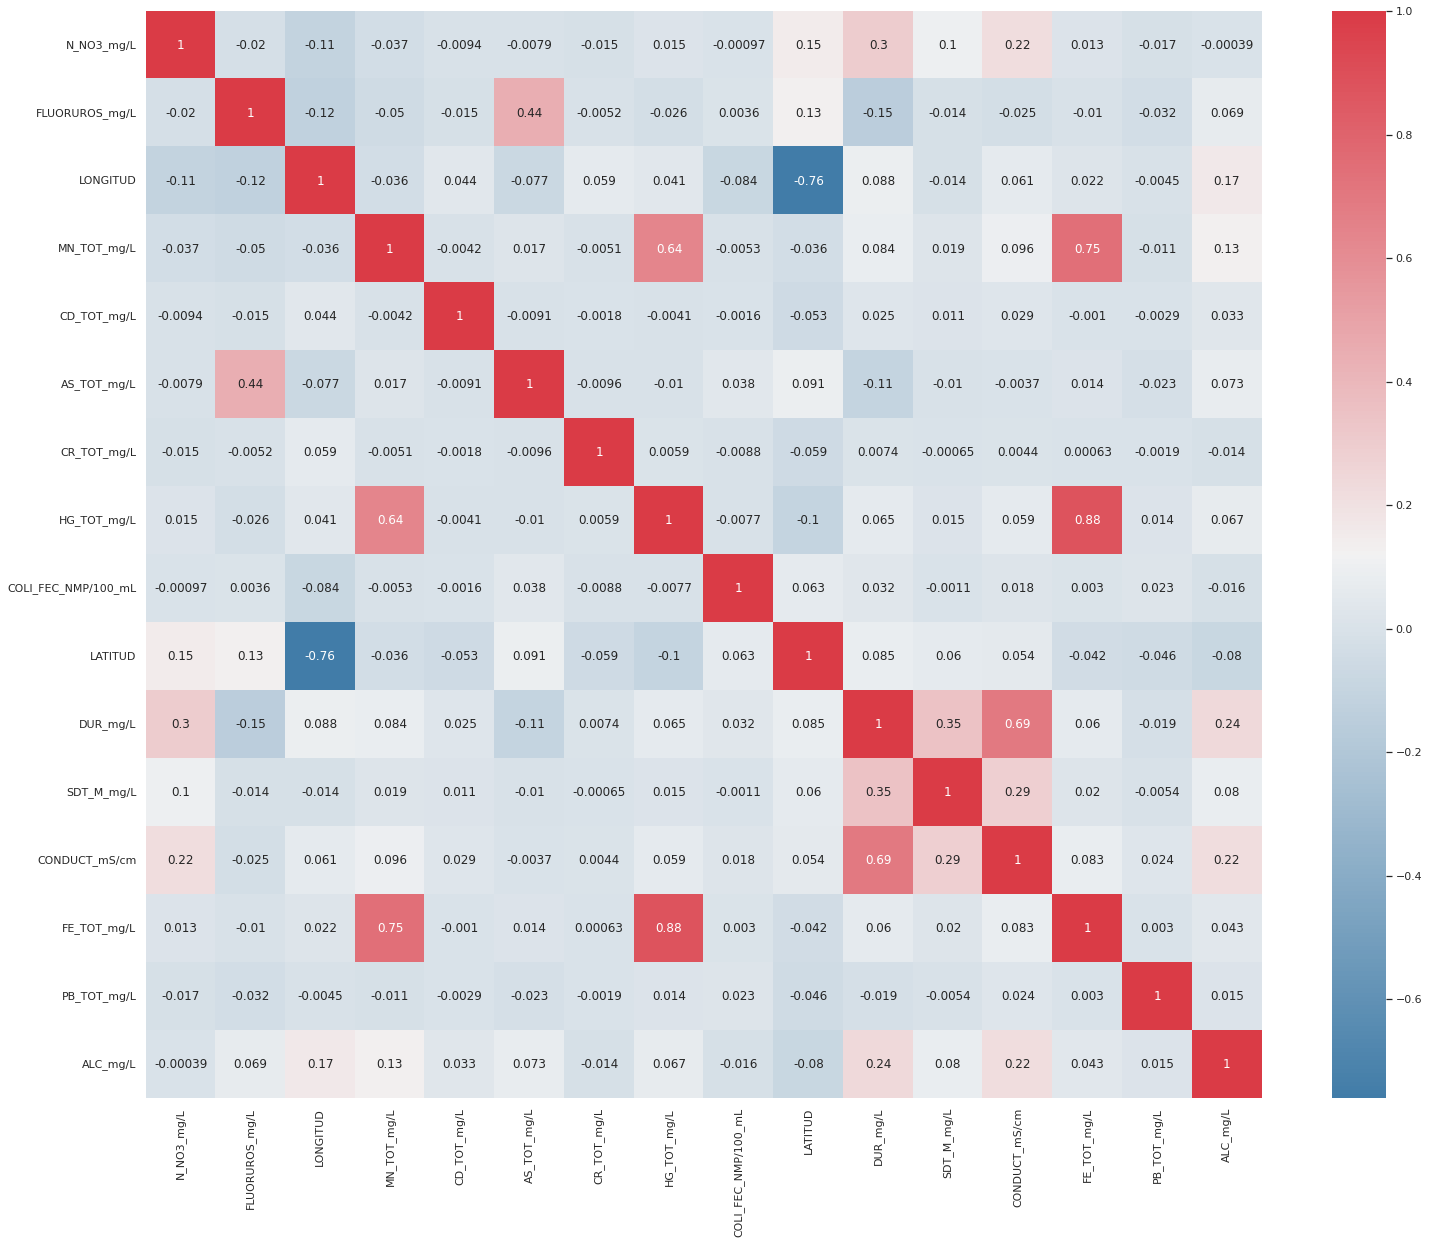

In [ ]:
featureLabels={'CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO',
       'ACUIFERO', 'SUBTIPO', 'LONGITUD', 'LATITUD','ALC_mg/L',
       'CALIDAD_ALC', 'CONDUCT_mS/cm', 'CALIDAD_CONDUC',
       'SDT_M_mg/L', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'FLUORUROS_mg/L',
       'CALIDAD_FLUO', 'DUR_mg/L', 'CALIDAD_DUR', 'COLI_FEC_NMP/100_mL',
       'CALIDAD_COLI_FEC', 'N_NO3_mg/L', 'CALIDAD_N_NO3', 'AS_TOT_mg/L',
       'CALIDAD_AS', 'CD_TOT_mg/L', 'CALIDAD_CD', 'CR_TOT_mg/L', 'CALIDAD_CR',
       'HG_TOT_mg/L', 'CALIDAD_HG', 'PB_TOT_mg/L', 'CALIDAD_PB', 'MN_TOT_mg/L',
       'CALIDAD_MN', 'FE_TOT_mg/L', 'CALIDAD_FE','CONTAMINANTES',
       'CUMPLE_CON_ALC'}
yValue=pd.Series(dfsub.loc[:,"SEMAFORO"])
dfsubFeatures=pd.DataFrame(dfsub,columns=featureLabels)  
xValue=pd.DataFrame(dfsub,columns=quantitative_features) 
fig = plt.figure(figsize=(25, 20))

sns.heatmap(dfsubFeatures.corr(), annot=True,cmap=sns.diverging_palette(240, 10, n=9,as_cmap=True))

---
Encontramos las siguientes correlaciones fuertes:

* HG_TOT_mg/L - FE_TOT_mg/L = 0.88
* MN_TOT_mg/L - FE_TOT_mg/L = 0.75
* CONDUCT_mS/cm - DUR_mg/L = 0.69
* MN_TOT_mg/L - HG_TOT_mg/L = 0.64

Correlaciones moderadas: 

* AS_TOT_mg/L - FLUORUROS_mg/L = 0.44
* DUR_mg/L - SDT_M_mg/L = 0.35
* DUR_mg/L - N_NO3_mg/L = 0.3
* CONDUCT_mS/cm - SDT_M_mg/L = 0.29
* CONDUCT_mS/cm - N_NO3_mg/L = 0.22

Por otro lado, observemos los valores atípicos.

---

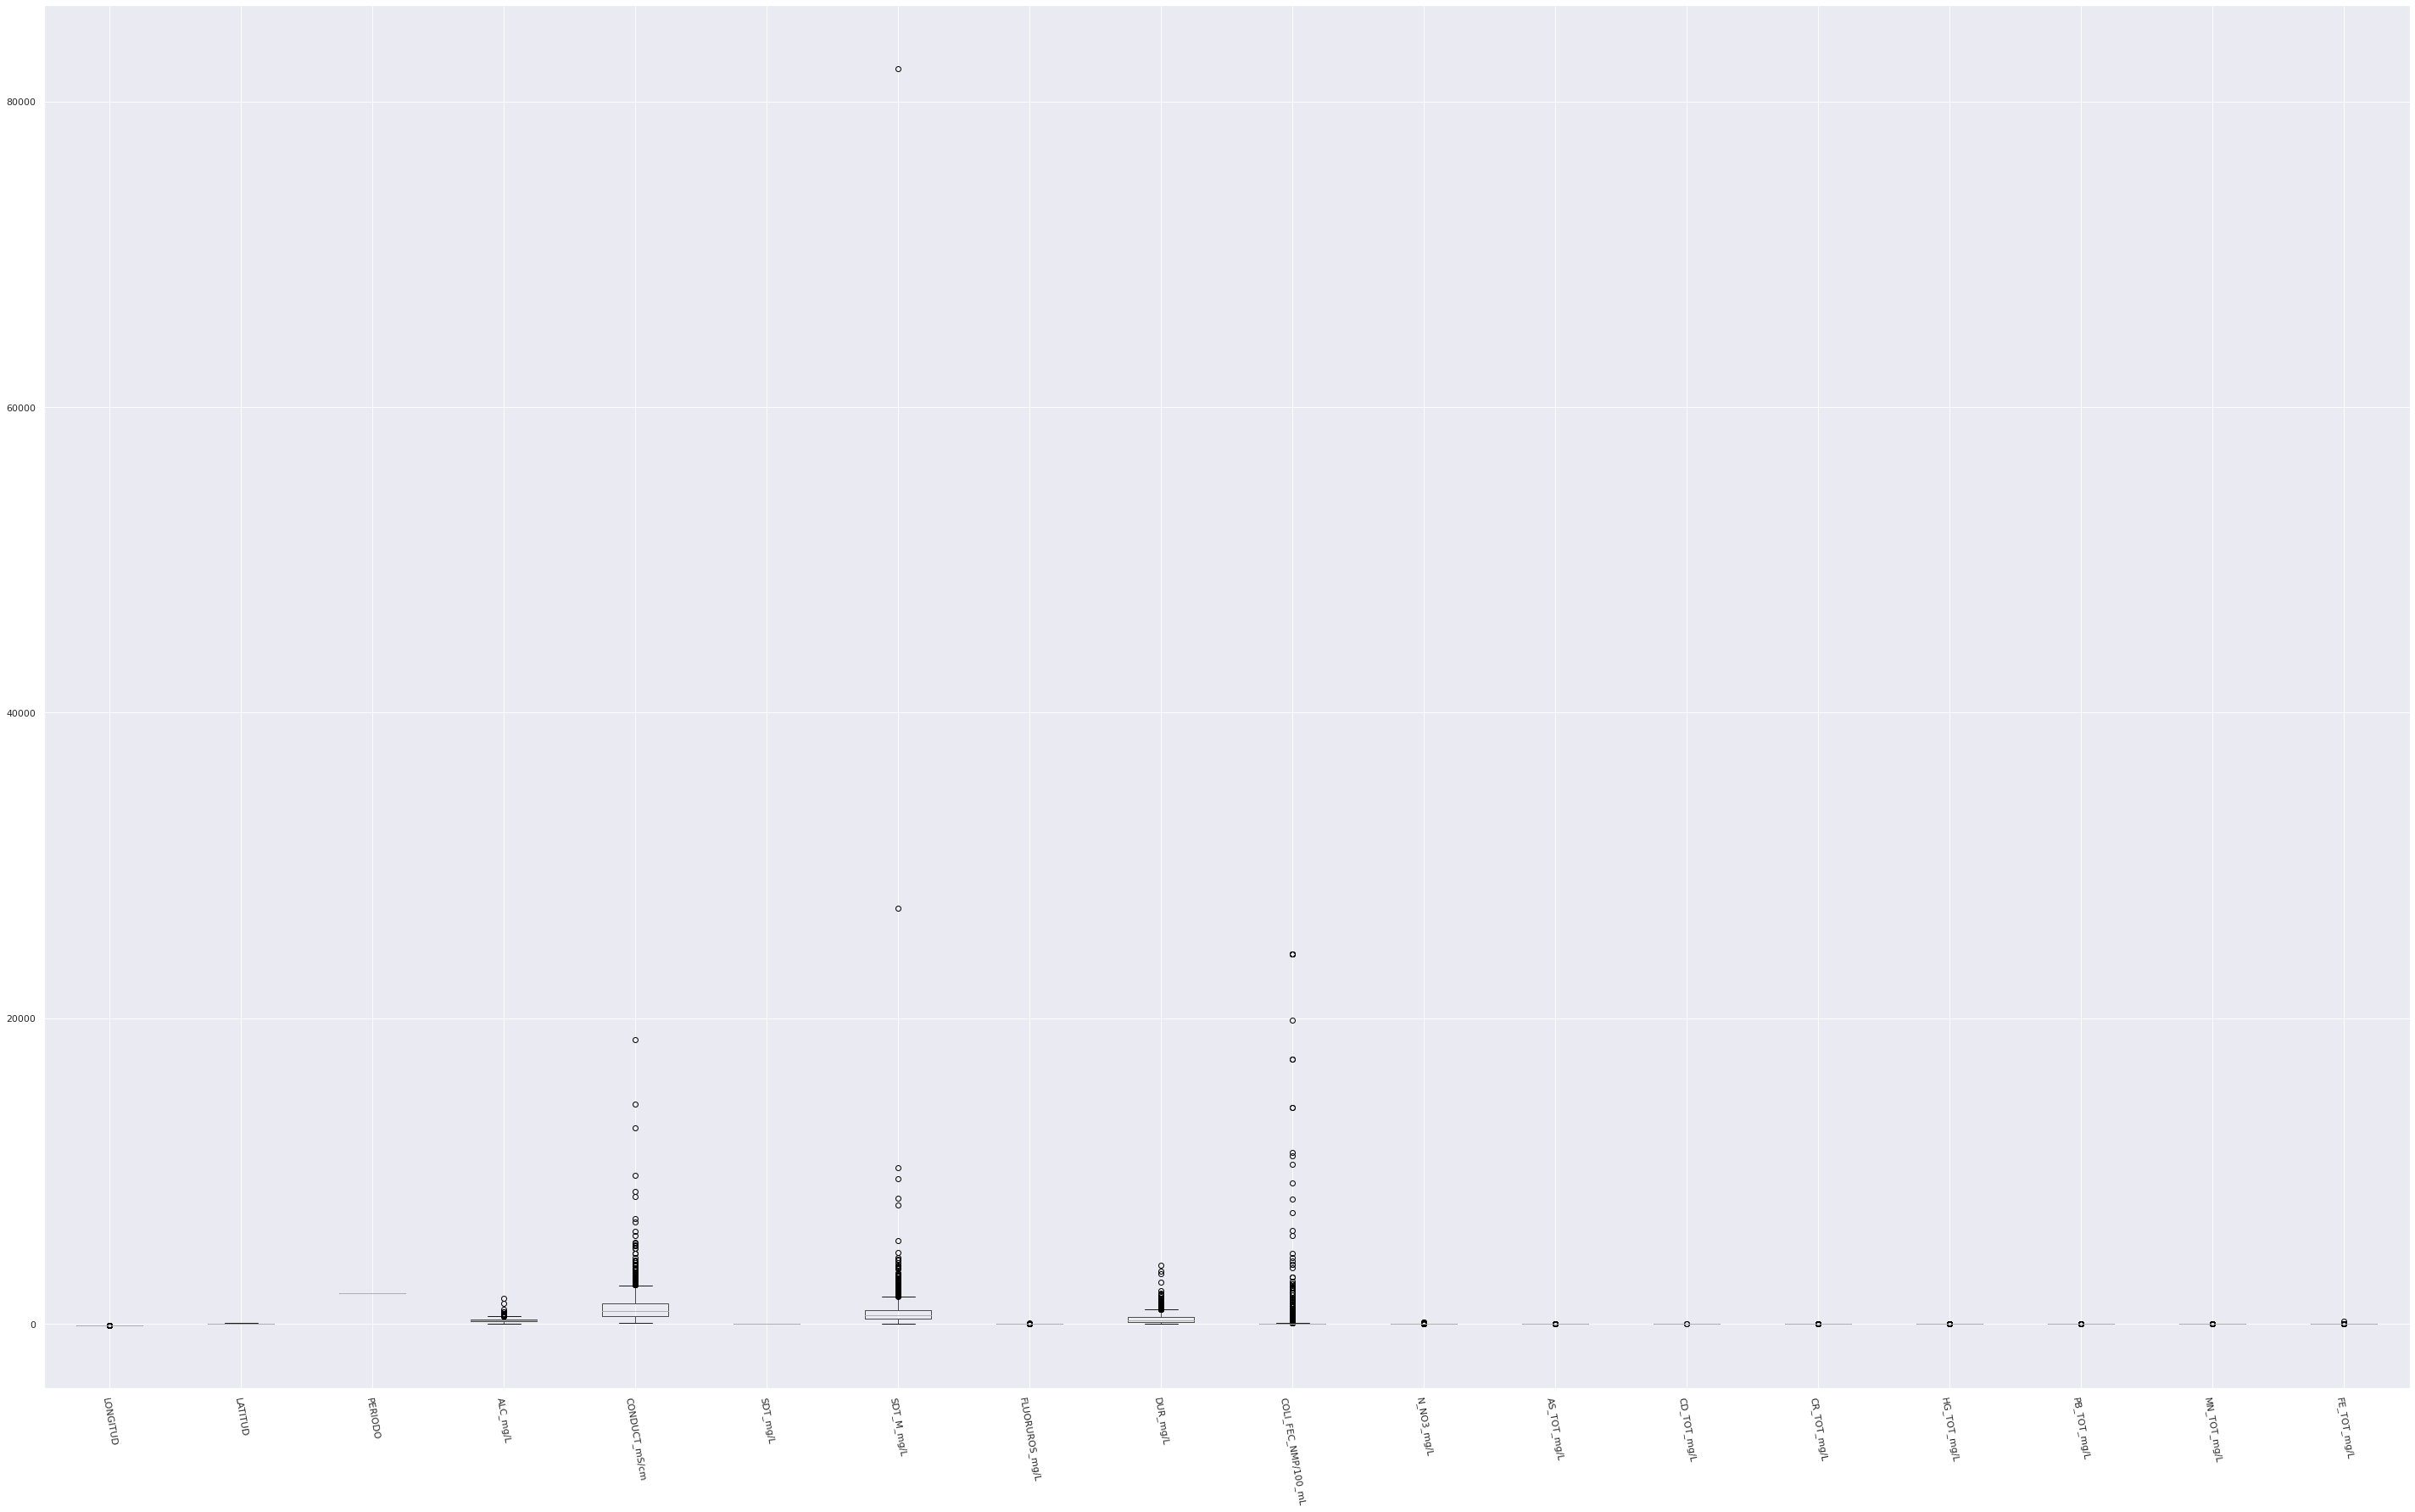

In [ ]:
xValue.boxplot(rot=1000)

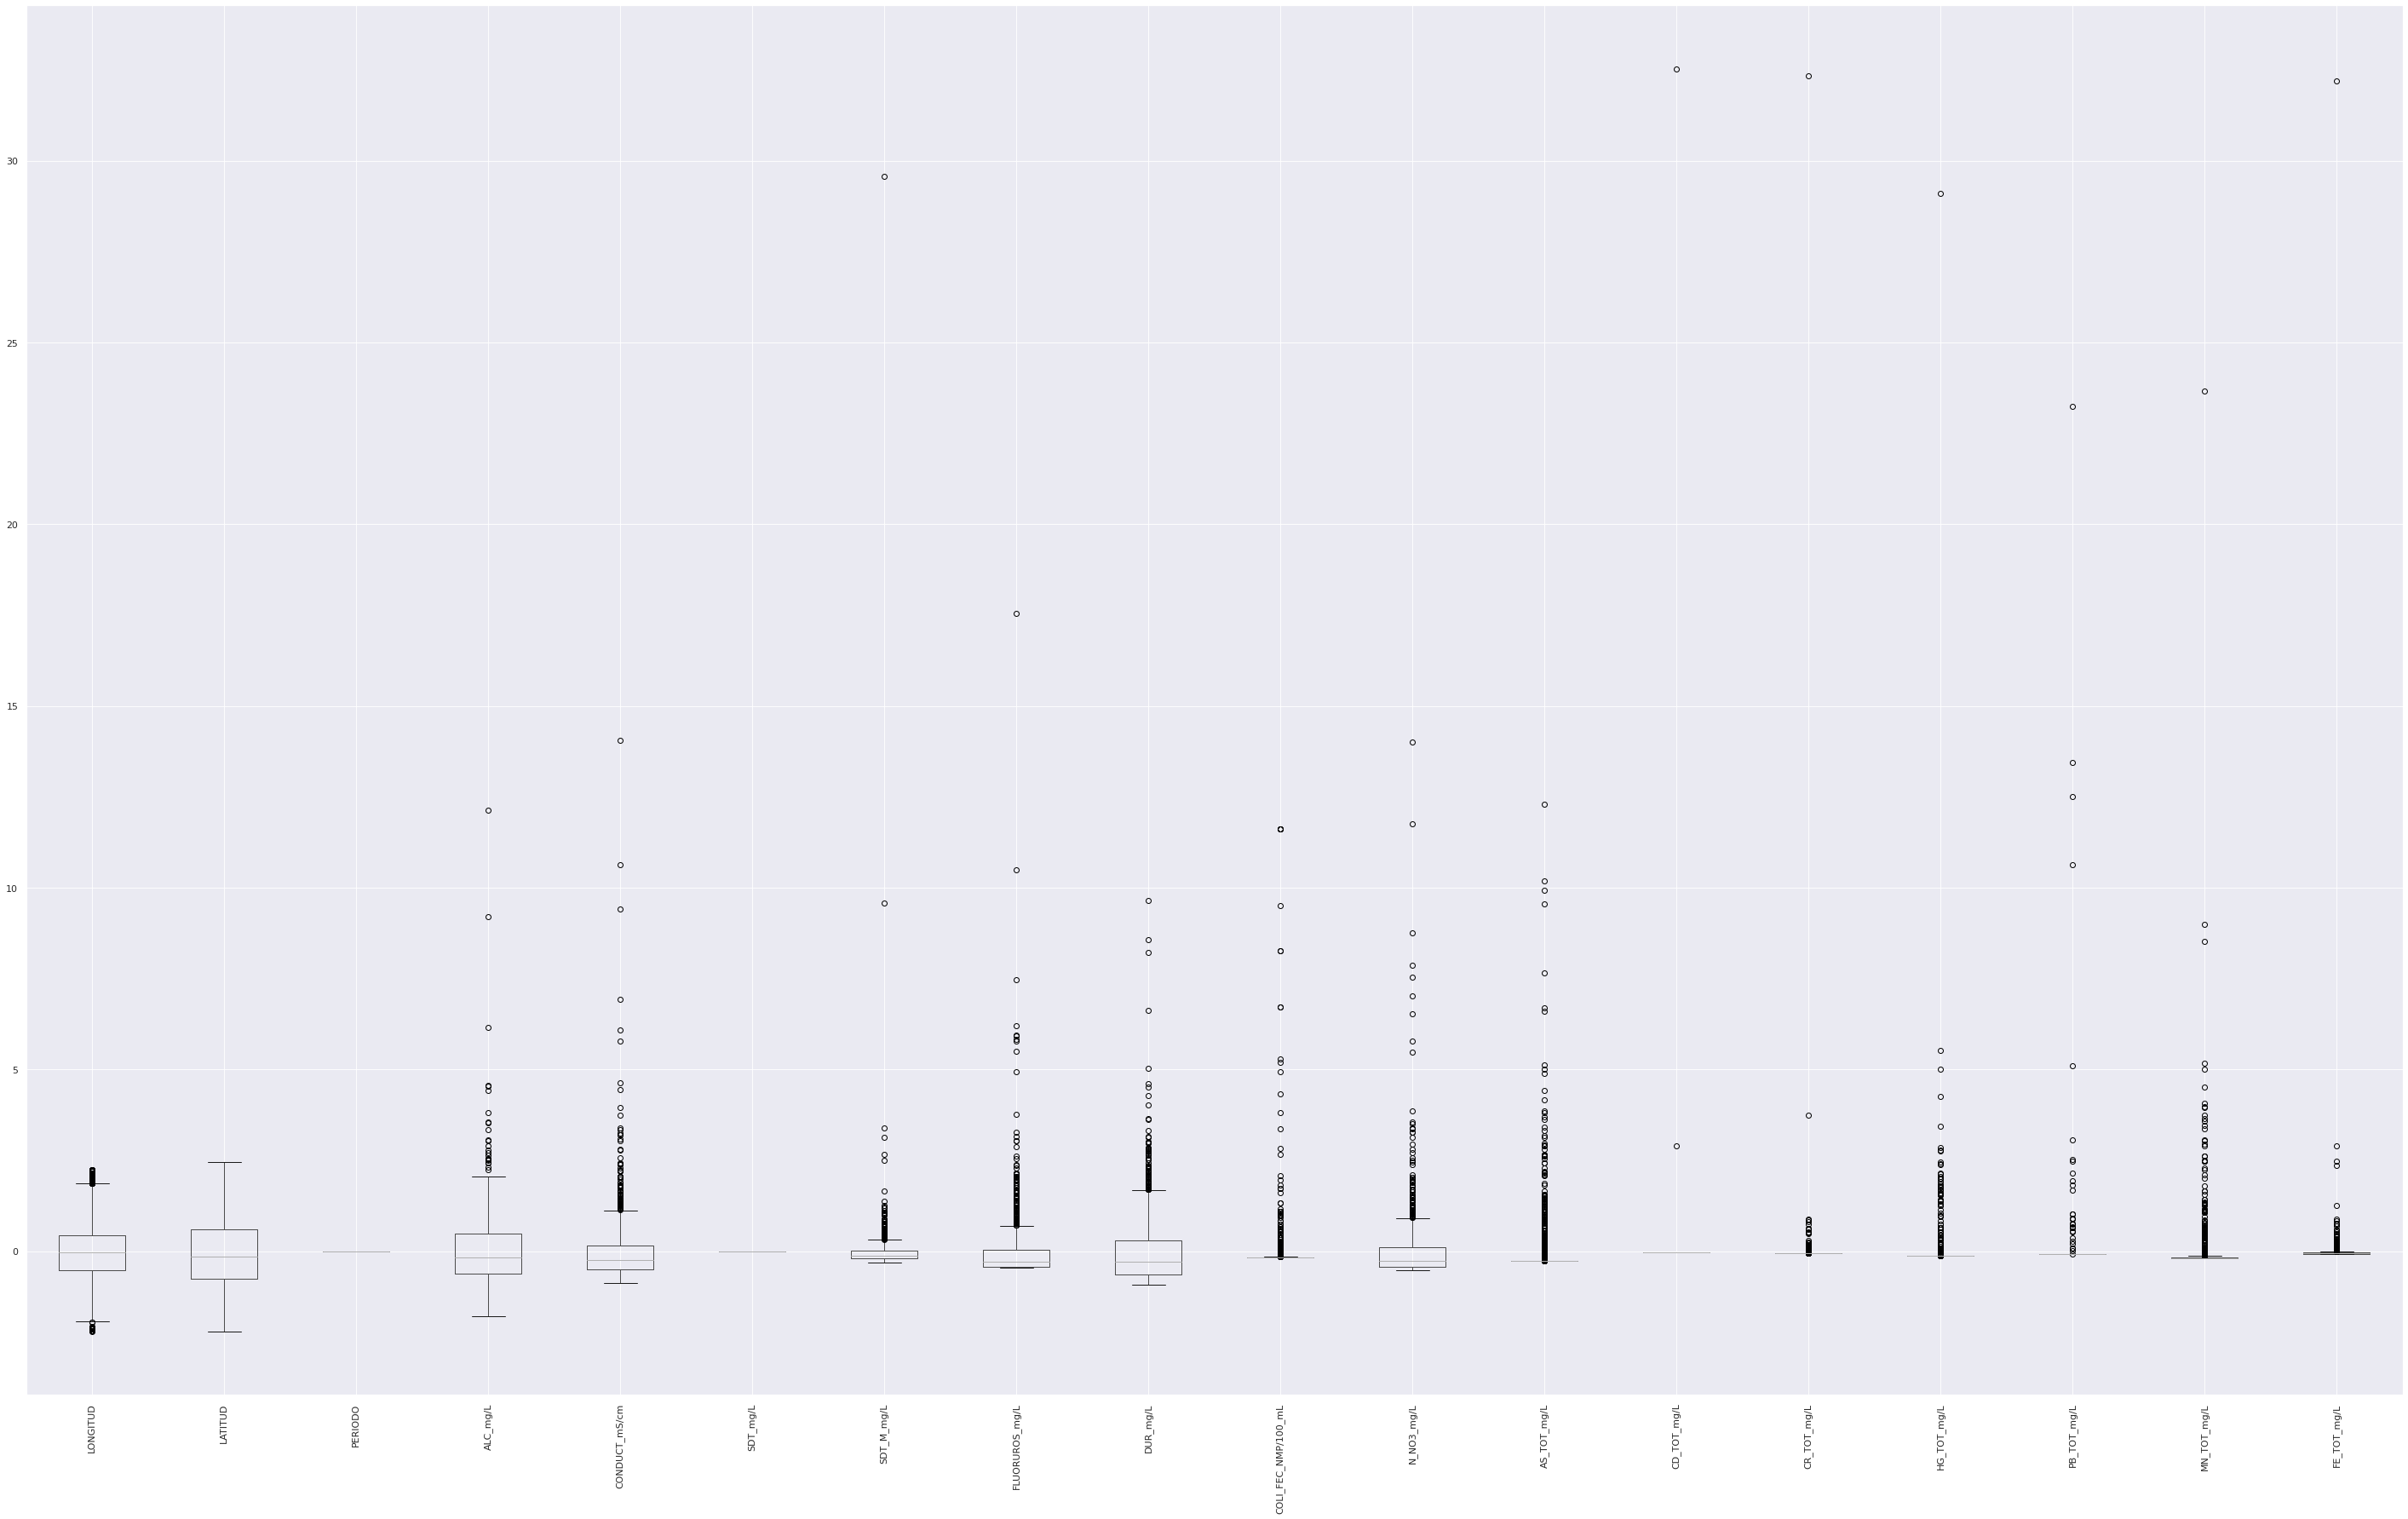

In [ ]:
from sklearn.preprocessing import StandardScaler #Normalizando estos valores, para observarlos mejor
import numpy as np
sc = StandardScaler()
X_scaled = sc.fit_transform(xValue)
pd.DataFrame(X_scaled,columns=quantitative_features).boxplot(rot=90)

---
Observamos nuestra variable de salida

---

In [ ]:
yValue

0          Verde
1          Verde
2           Rojo
3          Verde
4           Rojo
5           Rojo
6          Verde
7           Rojo
8          Verde
9           Rojo
10         Verde
11         Verde
12          Rojo
13          Rojo
14          Rojo
15         Verde
16         Verde
17      Amarillo
18          Rojo
19         Verde
20          Rojo
21      Amarillo
22         Verde
23          Rojo
24      Amarillo
25         Verde
26         Verde
27         Verde
28          Rojo
29          Rojo
30         Verde
31          Rojo
32         Verde
33          Rojo
34         Verde
35         Verde
36          Rojo
37      Amarillo
38      Amarillo
39      Amarillo
40         Verde
41         Verde
42         Verde
43         Verde
44          Rojo
45      Amarillo
46          Rojo
47          Rojo
48         Verde
49          Rojo
50         Verde
51         Verde
52          Rojo
53      Amarillo
54      Amarillo
55      Amarillo
56         Verde
57      Amarillo
58      Amaril

---
Observaremos nuestra varianza acomulada.

---

Eigenvalues:
[2.62529115e+00 2.09165802e+00 1.92220844e+00 1.42153306e+00
 1.03173192e+00 1.00586195e+00 9.90582907e-01 9.65183848e-01
 8.99230819e-01 8.60098841e-01 6.82756903e-01 5.56565251e-01
 3.62528898e-01 2.90668894e-01 2.12865200e-01 9.62292042e-02
 7.67303448e-33 4.10443784e-33]

Variances (Percentage):
[1.63927063e+01 1.30606221e+01 1.20025539e+01 8.87626272e+00
 6.44228677e+00 6.28075083e+00 6.18534622e+00 6.02675073e+00
 5.61493026e+00 5.37058440e+00 4.26323511e+00 3.47527576e+00
 2.26368407e+00 1.81497958e+00 1.32916180e+00 6.00869387e-01
 4.79115624e-32 2.56287171e-32]



Text(0, 0.5, 'Explained variance (%)')

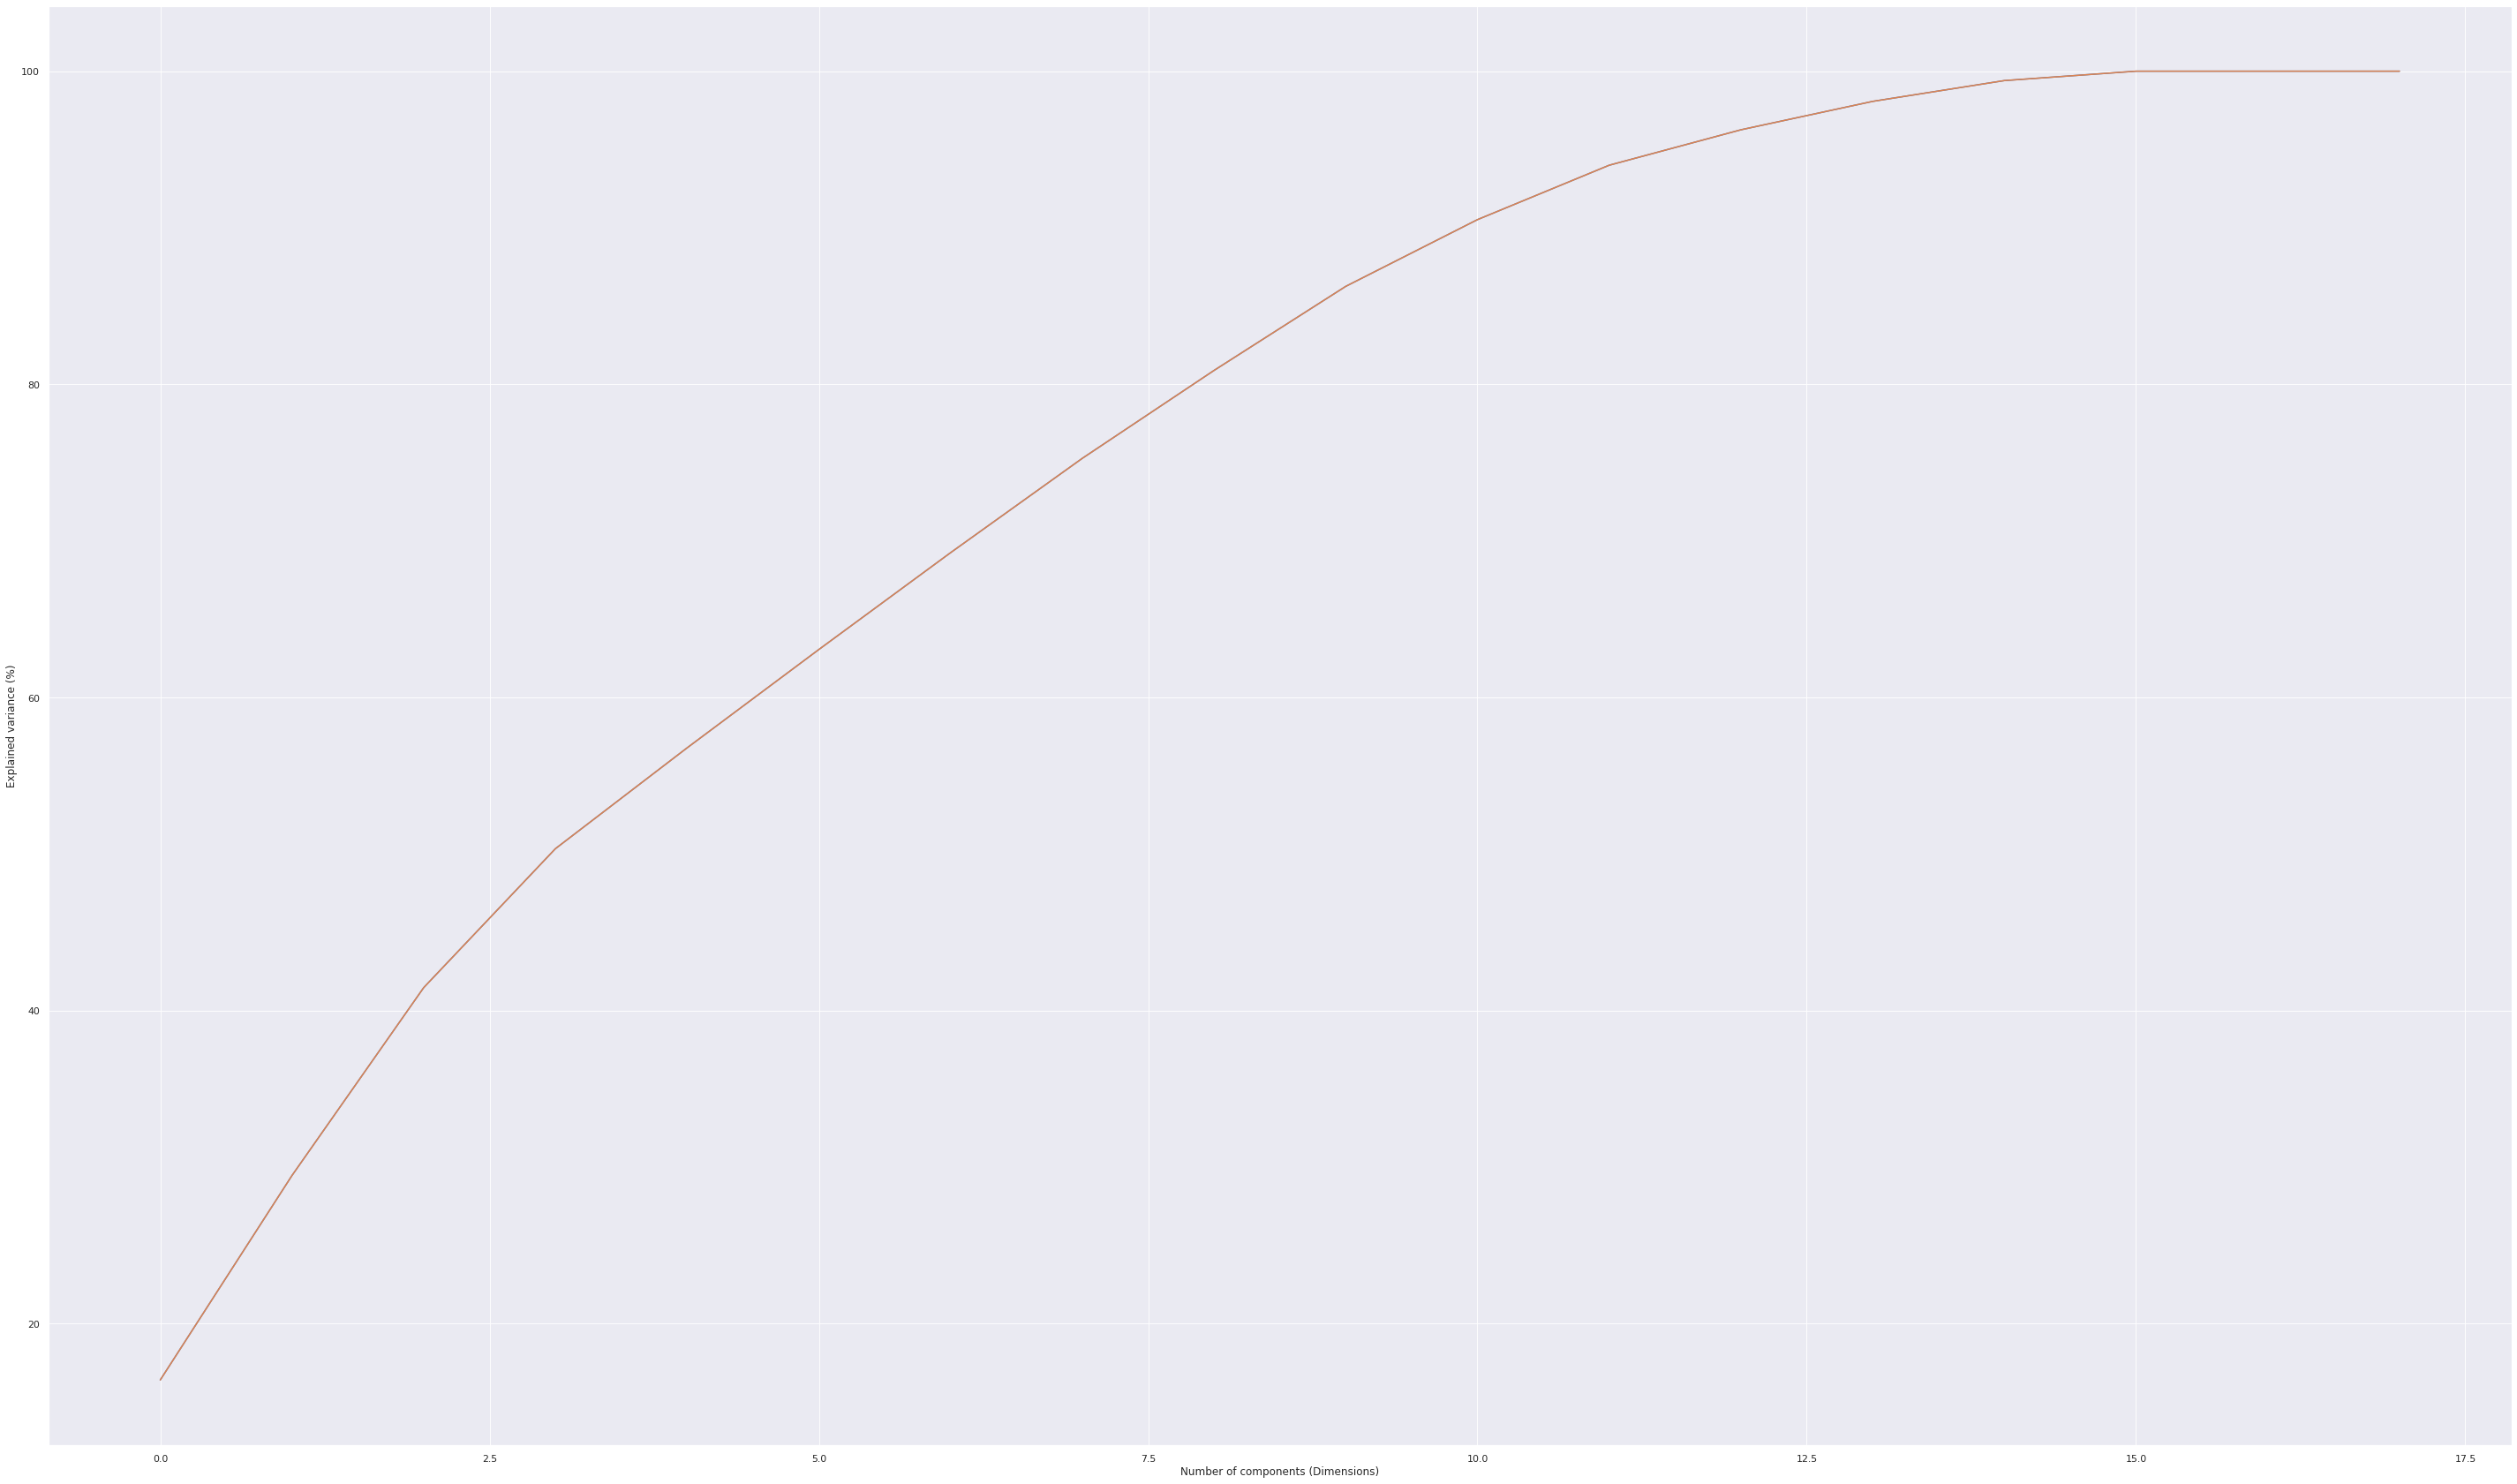

In [ ]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
import numpy as np
#sc = StandardScaler()
#X_scaled = sc.fit_transform(quantitative_transformer)

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

---
Observamos la importancia de las variables en cada componente

---

Text(201.5, 0.5, 'Explained variance (%)')

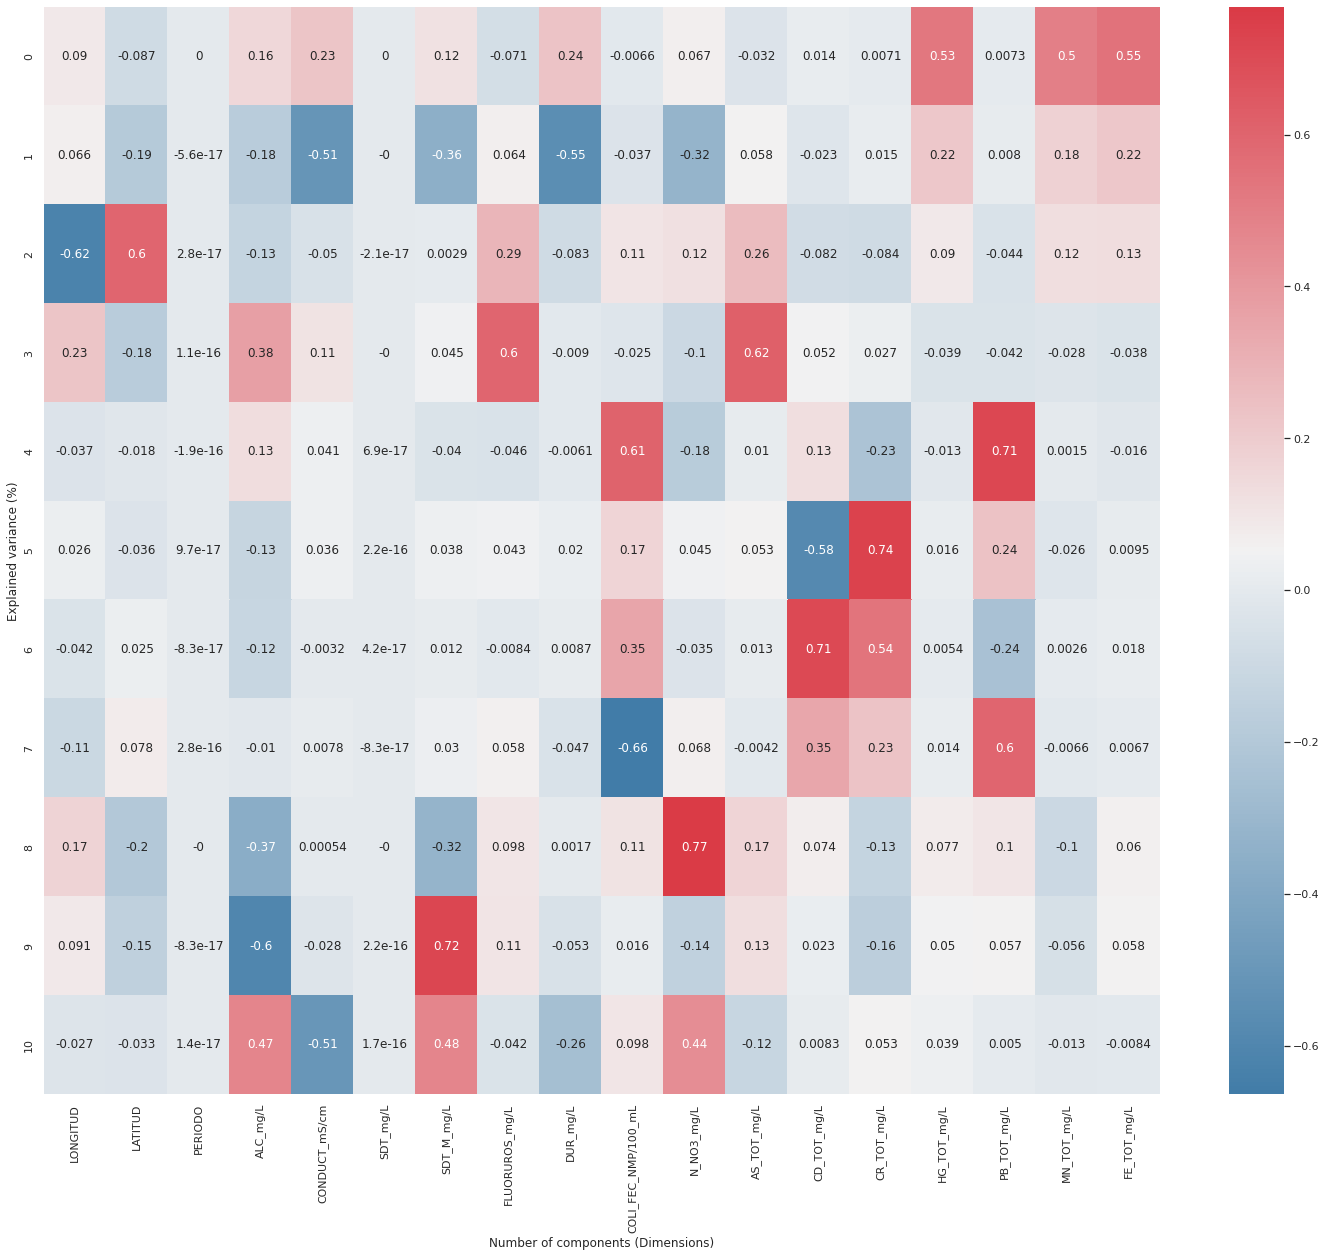

In [ ]:
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.scale(xValue),columns = xValue.columns) 

# Alicar PCA
from sklearn.decomposition import PCA
pca = PCA(0.9)
X_pca = pca.fit_transform(data_scaled)

# Obtener el dataset transformado
X_pca = pd.DataFrame(X_pca)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
fig = plt.figure(figsize=(25, 20))
cmap=sns.diverging_palette(240, 10, n=9,as_cmap=True)
sns.heatmap(pd.DataFrame(pca.components_,columns=data_scaled.columns), annot=True,cmap=cmap)

values=(pd.DataFrame(pca.components_,columns=data_scaled.columns).abs().max().sort_values(ascending = False))
(values)


plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

In [ ]:
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1068 non-null   float64
 1   1       1068 non-null   float64
 2   2       1068 non-null   float64
 3   3       1068 non-null   float64
 4   4       1068 non-null   float64
 5   5       1068 non-null   float64
 6   6       1068 non-null   float64
 7   7       1068 non-null   float64
 8   8       1068 non-null   float64
 9   9       1068 non-null   float64
 10  10      1068 non-null   float64
dtypes: float64(11)
memory usage: 91.9 KB


---
## **Ejercicio 3. Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.**

---

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

Empezamos almacenando nuestros datos de latitud y longitud en un nuevo DF

In [ ]:
latlong=dfsub[["LATITUD","LONGITUD"]] 

---
Visualizamos nuestros datos para observar algun patrón.

---

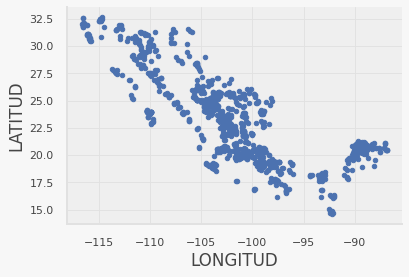

In [ ]:
latlong.plot.scatter("LONGITUD","LATITUD")

---
Para tener una mejor comprensión, observaremos nuestras métricas estadisticas.

---

In [ ]:
latlong.describe()

,LATITUD,LONGITUD
count,1068.000000,1068.000000
mean,23.163618,-101.891007
std,3.887670,6.703263
min,14.561150,-116.664250
25%,20.212055,-105.388865
50%,22.617190,-102.174180
75%,25.510285,-98.974716
max,32.677713,-86.864120


--- 
En nuestro DF agregaremos una nueva columna para tener el punto, que nos permita graficar apropiadamente en el mapa.

---

In [ ]:
dfsub["Coordenadas"] = list(zip(dfsub.LONGITUD, dfsub.LATITUD))
dfsub["Coordenadas"] = dfsub["Coordenadas"].apply(Point)
dfsub['color'] = dfsub['SEMAFORO'].replace({'Verde':'green','Amarillo':'yellow','Rojo':'red'}, inplace = True)

In [ ]:
gdf = gpd.GeoDataFrame(dfsub, geometry="Coordenadas")
gdf.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CALIDAD_ALC,CONDUCT_mS/cm,CALIDAD_CONDUC,SDT_mg/L,SDT_M_mg/L,CALIDAD_SDT_ra,CALIDAD_SDT_salin,FLUORUROS_mg/L,CALIDAD_FLUO,DUR_mg/L,CALIDAD_DUR,COLI_FEC_NMP/100_mL,CALIDAD_COLI_FEC,N_NO3_mg/L,CALIDAD_N_NO3,AS_TOT_mg/L,CALIDAD_AS,CD_TOT_mg/L,CALIDAD_CD,CR_TOT_mg/L,CALIDAD_CR,HG_TOT_mg/L,CALIDAD_HG,PB_TOT_mg/L,CALIDAD_PB,MN_TOT_mg/L,CALIDAD_MN,FE_TOT_mg/L,CALIDAD_FE,SEMAFORO,CONTAMINANTES,CUMPLE_CON_ALC,CUMPLE_CON_COND,CUMPLE_CON_SDT_ra,CUMPLE_CON_SDT_salin,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE,Coordenadas,color
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,Alta,940.0,Permisible para riego,0.0,603.6,Cultivos sensibles,Potable - Dulce,0.9766,Potable - Optima,213.7320,Potable - Dura,1.0,Potable - Excelente,4.184656,Potable - Excelente,0.0161,Apta como FAAP,0.00299,Potable - Excelente,0.00499,Potable - Excelente,0.000499,Potable - Excelente,0.00499,Potable - Excelente,0.001499,Potable - Excelente,0.08910,Potable - Excelente,green,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,POINT (-102.02210 22.20887),None
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,Alta,608.0,Buena para riego,0.0,445.4,Excelente para riego,Potable - Dulce,0.9298,Potable - Optima,185.0514,Potable - Dura,1.0,Potable - Excelente,5.750110,Potable - Buena calidad,0.0134,Apta como FAAP,0.00299,Potable - Excelente,0.00499,Potable - Excelente,0.000499,Potable - Excelente,0.00499,Potable - Excelente,0.001499,Potable - Excelente,0.02499,Potable - Excelente,green,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,POINT (-102.20075 21.99958),None
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,Alta,532.0,Buena para riego,0.0,342.0,Excelente para riego,Potable - Dulce,1.8045,Alta,120.7190,Potable - Dura,1.0,Potable - Excelente,1.449803,Potable - Excelente,0.0370,No apta como FAAP,0.00299,Potable - Excelente,0.00499,Potable - Excelente,0.000499,Potable - Excelente,0.00499,Potable - Excelente,0.001499,Potable - Excelente,0.02499,Potable - Excelente,red,"FLUO,AS,",SI,SI,SI,SI,NO,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,POINT (-102.28801 22.36685),None
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,Alta,686.0,Buena para riego,0.0,478.6,Excelente para riego,Potable - Dulce,1.1229,Potable - Optima,199.8790,Potable - Dura,1.0,Potable - Excelente,1.258597,Potable - Excelente,0.0154,Apta como FAAP,0.00299,Potable - Excelente,0.00500,Potable - Excelente,0.000499,Potable - Excelente,0.00499,Potable - Excelente,0.001499,Potable - Excelente,0.02499,Potable - Excelente,green,NaN,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,POINT (-102.29449 22.18435),None
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,Alta,1841.0,Permisible para riego,0.0,1179.0,Cultivos con manejo especial,Ligeramente salobres,0.2343,Baja,476.9872,Potable - Dura,291.0,Aceptable,15.672251,No apta como FAAP,0.0099,Potable - Excelente,0.00299,Potable - Excelente,0.00499,Potable - Excelente,0.000499,Potable - Excelente,0.00499,Potable - Excelente,0.001499,Potable - Excelente,0.02499,Potable - Excelente,red,"NO3,",SI,SI,SI,SI,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI,POINT (-110.24480 23.45138),None


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

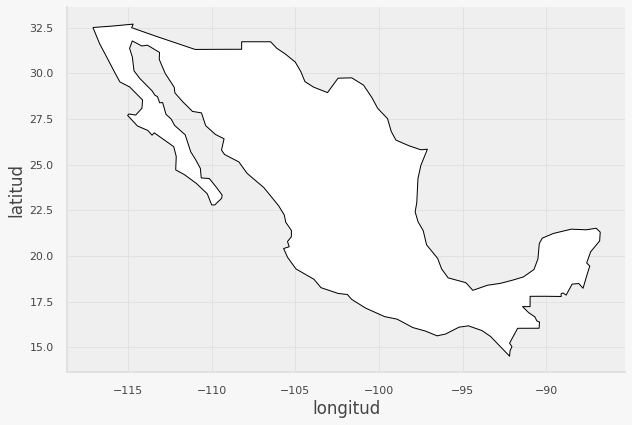

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# Vamos a graficar solamente Mexico
world.query("name == 'Mexico'").plot(ax=gax, edgecolor='black',color='white')
gax.set_xlabel('longitud')
gax.set_ylabel('latitud')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

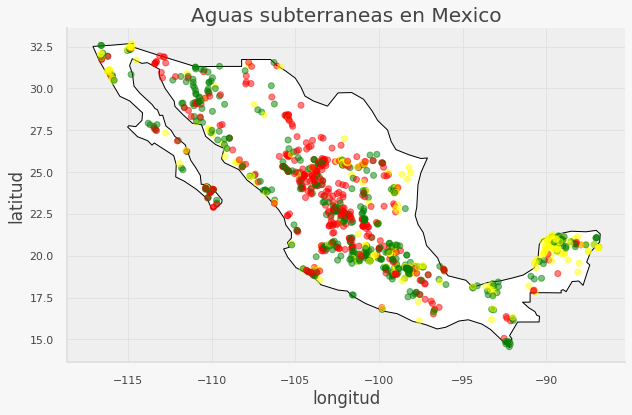

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))


world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color=dfsub['SEMAFORO'], alpha = 0.5)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Aguas subterraneas en Mexico')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

---
Teniendo en cuenta las practicas anteriores, utilizaremos el metodo del codo el cual nos permite producir una función de costo para encontrar relaciones.

---

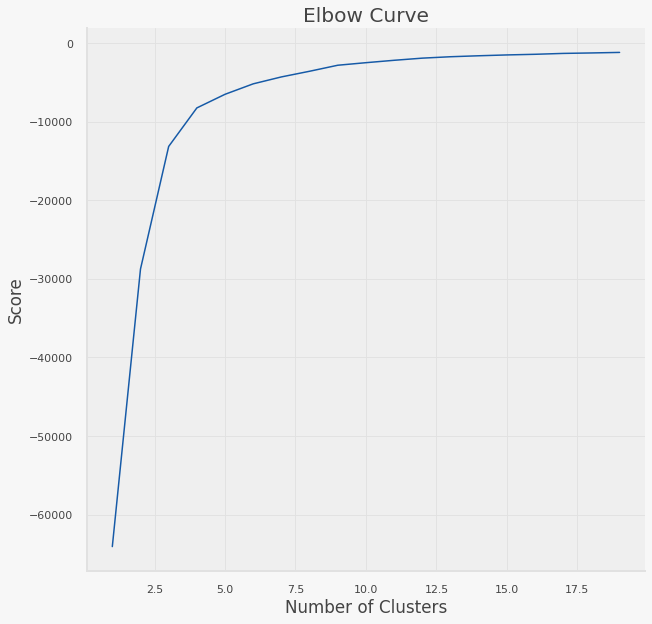

In [ ]:
#Para este paso importaremos la libreria de sklearn cluster para trabajar con kmeans
from sklearn.cluster import KMeans
X = dfsub[["LONGITUD","LATITUD"]]

#De esta manera definiremos nuestra elbow curve para determinar la cantidad optima de clusters que vamos a requerir.
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.subplots(figsize=(10,10))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
#Ahora vamos a poder elegir los 5 clusters que nos daran las coordenadas donde más fuentes de agua subterraneas tenemos
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X)
C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C)
C_DF["Coordenadas"] = list(zip(C_DF[0], C_DF[1]))
C_DF["Coordenadas"] = C_DF["Coordenadas"].apply(Point)


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordenadas")
gdf_C

,0,1,Coordenadas
0,-100.126474,19.825118,POINT (-100.12647 19.82512)
1,-102.578733,24.205547,POINT (-102.57873 24.20555)
2,-90.092716,19.650263,POINT (-90.09272 19.65026)
3,-112.587985,30.316491,POINT (-112.58799 30.31649)
4,-107.791999,25.853527,POINT (-107.79200 25.85353)


---
Graficaremos de nuevo nuestro mapa para ver donde estan los puntos que mas fuentes de agua subterranea tienen.

---

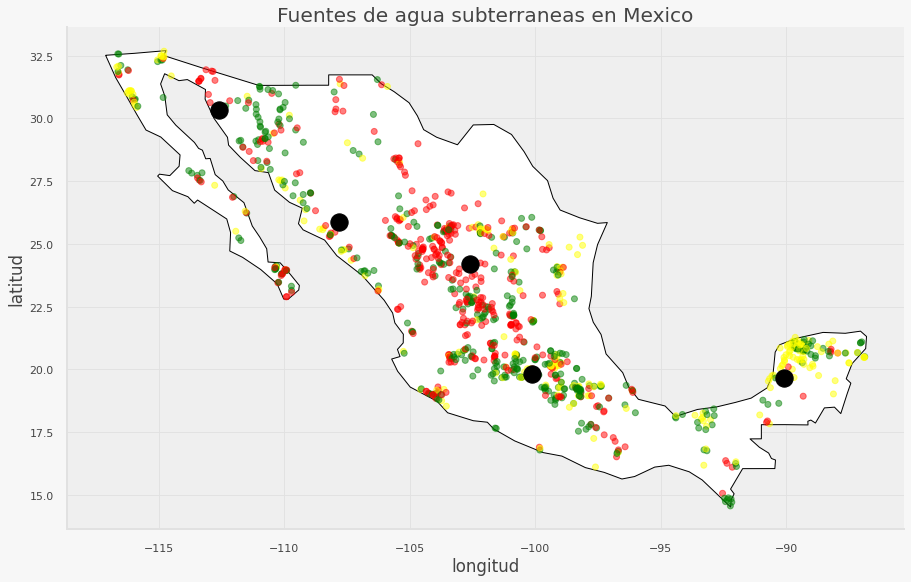

In [ ]:
fig, gax = plt.subplots(figsize=(15,10))
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')


gdf.plot(ax=gax, color=dfsub['SEMAFORO'], alpha = 0.5)
gdf_C.plot(ax=gax, color='black', alpha = 1, markersize = 300)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Fuentes de agua subterraneas en Mexico')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [ ]:
#Realizaremos el conteo de fuentes de agua subterranea por cluster
latlong['kmeans'] = kmeans.labels_
latlong.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    324
1    303
2    162
4    148
3    131
Name: kmeans, dtype: int64

In [ ]:
#Si recordamos las coordenadas que obtuvimos arriba, vamos a determinar en donde se encuentran exactamente, para lo cual es importante realizar una concatenación de la latitud y longitud.
from pandas.core.internals.concat import concat_arrays

print(gdf_C[0][0])
print(gdf_C[1][0])

Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0])
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)
Location4 = str(gdf_C[1][3]) + ", " + str(gdf_C[0][3])
print(Location4)
Location5 = str(gdf_C[1][4]) + ", " + str(gdf_C[0][4])
print(Location5)

-100.1264737191358
19.825117805555557
19.825117805555557, -100.1264737191358
24.205547376237625, -102.57873341914191
19.6502625, -90.09271577777778
30.31649148091603, -112.58798516030535
25.853526891891892, -107.79199926351352


In [ ]:
#posteriormente, mediante la libreria geopy podemos tomar estos datos concatenados y observar la ubicación exacta de los lugares
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application")
Locations = [Location1, Location2, Location3, Location4, Location5]
for i in Locations:
  location = geolocator.reverse(i)

  print(location.address)

locations1 = geolocator.reverse(Location1)
locations2 = geolocator.reverse(Location2)



El Oro, Estado de México, 50600, México
General Francisco R. Murguía, Zacatecas, México
Municipio de Campeche, Campeche, México
Caborca, Sonora, México
Municipio de Sinaloa, Sinaloa, México


### **Comentarios Finales**

---
* De acuerdo a este analisis observamos que en la zona centro es donde más fuentes de agua no tan buenas tenemos, seguido de un sector de la zona sur y otro de la norte, lo cual es de entenderse ya que por la cantidad de personas y el movimiento diario se produce más contaminación, caso opuesto a algunas zonas costeras o no tan pobladas que logramos encontrar buenos resultados en cuanto la calidad del agua. 

---

---
#**Base 2 - Aguas superficiales**
---

---
##**Ejercicio 1. Limpieza de la base de datos**

---

In [ ]:
df2 = pd.read_csv(db_aguas_superficiales,encoding='cp1252')
dfsup= df2.copy()
dfsup.head(5)

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,<1,No Toxico,NaN,NaN,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,NaN,NaN,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


---
Calculamos el tamaño de nuestra base de datos

---

In [ ]:
dfsup.shape

(4141, 55)

---
Con el metodo info consultamos la información general de los datos 

---

In [ ]:
dfsup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

---
* Revisando el dataset y los tipos de variables iniciales, es necesario realizar modificaciones para cambiar de tipo, pero de acuerdo a la base de datos compartida no tenemos información de los tipos de dato, así que realizando una exploración de las 5 primeras columnas pudimos observar que tipo de información se tiene y de ese modo asignarle el tipo de dato más adecuado, que nos permita realizar un apropiado analisis y los respectivos pipelines en caso de que sea requerido para desarrollar algun modelo de aprendizaje automatico.
* Revisamos si tenemos valores nulos
---

In [ ]:
dfsup.isna().any()

CLAVE                     True
SITIO                     True
ORGANISMO_DE_CUENCA       True
ESTADO                    True
MUNICIPIO                 True
CUENCA                    True
CUERPO DE AGUA            True
TIPO                      True
SUBTIPO                   True
LONGITUD                  True
LATITUD                   True
PERIODO                   True
DBO_mg/L                  True
CALIDAD_DBO               True
DQO_mg/L                  True
CALIDAD_DQO               True
SST_mg/L                  True
CALIDAD_SST               True
COLI_FEC_NMP_100mL        True
CALIDAD_COLI_FEC          True
E_COLI_NMP_100mL          True
CALIDAD_E_COLI            True
ENTEROC_NMP_100mL         True
CALIDAD_ENTEROC           True
OD_PORC                   True
CALIDAD_OD_PORC           True
OD_PORC_SUP               True
CALIDAD_OD_PORC_SUP       True
OD_PORC_MED               True
CALIDAD_OD_PORC_MED       True
OD_PORC_FON               True
CALIDAD_OD_PORC_FON       True
TOX_D_48

---
A continuación se modifican los tipos de variables de acuerdo a los hallazgos correspondientes. Pero primero se debe reemplazar los valores en unas variables que son de tipo numerico pero aparecen con datos del estilo < 1.1 lo cual al transformace a numero va a generar error de tipo si quisieramos hacer alguna operación matematica con ellos. 

---

In [ ]:
dfsup['DBO_mg/L'].replace({'<2':1.99}, inplace = True)  
dfsup['DQO_mg/L'].replace({'<10':9.99}, inplace = True) 
dfsup['SST_mg/L'].replace({'<10':9.99}, inplace = True) 
dfsup['COLI_FEC_NMP_100mL'].replace({'<3':2.99}, inplace = True) 
dfsup['E_COLI_NMP_100mL'].replace({'<3':2.99}, inplace = True)  
dfsup['ENTEROC_NMP_100mL'].replace({'<3':2.99}, inplace = True)  
dfsup['OD_PORC'].replace({'<10':9.99}, inplace = True)  
dfsup['OD_PORC_SUP'].replace({'<10':9.99}, inplace = True)
dfsup['OD_PORC_MED'].replace({'<10':9.99}, inplace = True)
dfsup['OD_PORC_FON'].replace({'<10':9.99}, inplace = True) 
dfsup['TOX_D_48_UT'].replace({'<1':0.99}, inplace = True) 
dfsup['TOX_V_15_UT'].replace({'<1':0.99}, inplace = True) 
dfsup['TOX_D_48_SUP_UT'].replace({'<1':0.99}, inplace = True) 
dfsup['TOX_FIS_SUP_15_UT'].replace({'<1':0.99}, inplace = True)

In [ ]:
dfsup['CLAVE'].fillna(value = 0, inplace = True)
dfsup['SITIO'].fillna(value = dfsup['SITIO'].mode()[0], inplace = True)
dfsup['ORGANISMO_DE_CUENCA'].fillna(value = dfsup['ORGANISMO_DE_CUENCA'].mode()[0], inplace = True)
dfsup['ESTADO'].fillna(value = dfsup['ESTADO'].mode()[0], inplace = True)
dfsup['MUNICIPIO'].fillna(value = dfsup['MUNICIPIO'].mode()[0], inplace = True)
dfsup['CUENCA'].fillna(value = dfsup['CUENCA'].mode()[0], inplace = True)
dfsup['CUERPO DE AGUA'].fillna(value = dfsup['CUERPO DE AGUA'].mode()[0], inplace = True)
dfsup['TIPO'].fillna(value = dfsup['TIPO'].mode()[0], inplace = True)
dfsup['SUBTIPO'].fillna(value = dfsup['SUBTIPO'].mode()[0], inplace = True)
dfsup['LONGITUD'].fillna(value = dfsup['LONGITUD'].median(), inplace = True)
dfsup['LATITUD'].fillna(value = dfsup['LATITUD'].median(), inplace = True)
dfsup['PERIODO'].fillna(value = 2020, inplace = True)
dfsup['DBO_mg/L'].fillna(value = dfsup['DBO_mg/L'].median(), inplace = True)
dfsup['CALIDAD_DBO'].fillna(value = dfsup['CALIDAD_DBO'].mode()[0], inplace = True)
dfsup['DQO_mg/L'].fillna(value = dfsup['DQO_mg/L'].median(), inplace = True)
dfsup['CALIDAD_DQO'].fillna(value = dfsup['CALIDAD_DQO'].mode()[0], inplace = True)
dfsup['SST_mg/L'].fillna(value = dfsup['SST_mg/L'].median(), inplace = True)
dfsup['CALIDAD_SST'].fillna(value = dfsup['CALIDAD_SST'].mode()[0], inplace = True)
dfsup['COLI_FEC_NMP_100mL'].fillna(value = dfsup['COLI_FEC_NMP_100mL'].median(), inplace = True)
dfsup['CALIDAD_COLI_FEC'].fillna(value = dfsup['CALIDAD_COLI_FEC'].mode()[0], inplace = True)
dfsup['E_COLI_NMP_100mL'].fillna(value = dfsup['E_COLI_NMP_100mL'].median(), inplace = True)
dfsup['CALIDAD_E_COLI'].fillna(value = dfsup['CALIDAD_E_COLI'].mode()[0], inplace = True)
dfsup['ENTEROC_NMP_100mL'].fillna(value = dfsup['ENTEROC_NMP_100mL'].median(), inplace = True)
dfsup['CALIDAD_ENTEROC'].fillna(value = dfsup['CALIDAD_ENTEROC'].mode()[0], inplace = True)
dfsup['OD_PORC'].fillna(value = dfsup['OD_PORC'].median(), inplace = True)
dfsup['CALIDAD_OD_PORC'].fillna(value = dfsup['CALIDAD_OD_PORC'].mode()[0], inplace = True)
dfsup['OD_PORC_SUP'].fillna(value = dfsup['OD_PORC_SUP'].median(), inplace = True)
dfsup['CALIDAD_OD_PORC_SUP'].fillna(value = dfsup['CALIDAD_OD_PORC_SUP'].mode()[0], inplace = True)
dfsup['OD_PORC_MED'].fillna(value = dfsup['OD_PORC_MED'].median(), inplace = True)
dfsup['CALIDAD_OD_PORC_MED'].fillna(value = dfsup['CALIDAD_OD_PORC_MED'].mode()[0], inplace = True)
dfsup['OD_PORC_FON'].fillna(value = dfsup['OD_PORC_FON'].median(), inplace = True)
dfsup['CALIDAD_OD_PORC_FON'].fillna(value = dfsup['CALIDAD_COLI_FEC'].mode()[0], inplace = True)
dfsup['TOX_D_48_UT'].fillna(value = dfsup['TOX_D_48_UT'].median(), inplace = True)
dfsup['CALIDAD_TOX_D_48'].fillna(value = dfsup['CALIDAD_TOX_D_48'].mode()[0], inplace = True)
dfsup['TOX_V_15_UT'].fillna(value = dfsup['TOX_D_48_UT'].median(), inplace = True)
dfsup['CALIDAD_TOX_V_15'].fillna(value = dfsup['CALIDAD_TOX_D_48'].mode()[0], inplace = True)
dfsup['TOX_D_48_SUP_UT'].fillna(value = dfsup['TOX_D_48_SUP_UT'].median(), inplace = True)
dfsup['CALIDAD TOX_D_48_SUP'].fillna(value = dfsup['CALIDAD TOX_D_48_SUP'].mode()[0], inplace = True)
dfsup['TOX_D_48_FON_UT'].fillna(value = 0, inplace = True)  #valores vacios en db
dfsup['CALIDAD_TOX_D_48_FON'].fillna(value = "vacio", inplace = True) #valores vacios en db
dfsup['TOX_FIS_SUP_15_UT'].fillna(value = dfsup['TOX_FIS_SUP_15_UT'].median(), inplace = True)
dfsup['CALIDAD_TOX_FIS_SUP_15'].fillna(value = dfsup['CALIDAD_TOX_FIS_SUP_15'].mode()[0], inplace = True)
dfsup['TOX_FIS_FON_15_UT'].fillna(value = 0, inplace = True) #valores vacios en db
dfsup['CALIDAD_TOX_FIS_FON_15'].fillna(value = "vacio", inplace = True) #valores vacios en db
dfsup['SEMAFORO'].fillna(value = dfsup['SEMAFORO'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_DBO'].fillna(value = dfsup['CUMPLE_CON_DBO'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_DQO'].fillna(value = dfsup['CUMPLE_CON_DQO'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_SST'].fillna(value = dfsup['CUMPLE_CON_SST'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_CF'].fillna(value = dfsup['CUMPLE_CON_CF'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_E_COLI'].fillna(value = dfsup['CUMPLE_CON_E_COLI'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_ENTEROC'].fillna(value = dfsup['CUMPLE_CON_ENTEROC'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_OD'].fillna(value = dfsup['CUMPLE_CON_OD'].mode()[0], inplace = True)
dfsup['CUMPLE_CON_TOX'].fillna(value = dfsup['CUMPLE_CON_TOX'].mode()[0], inplace = True)
dfsup['GRUPO'].fillna(value = dfsup['GRUPO'].mode()[0], inplace = True)



In [ ]:
dfsup.isna().any() #La unica variable que se deja con valores vacios es contaminantes ya que no necesariamente cada dato deba tenerlos

CLAVE                     False
SITIO                     False
ORGANISMO_DE_CUENCA       False
ESTADO                    False
MUNICIPIO                 False
CUENCA                    False
CUERPO DE AGUA            False
TIPO                      False
SUBTIPO                   False
LONGITUD                  False
LATITUD                   False
PERIODO                   False
DBO_mg/L                  False
CALIDAD_DBO               False
DQO_mg/L                  False
CALIDAD_DQO               False
SST_mg/L                  False
CALIDAD_SST               False
COLI_FEC_NMP_100mL        False
CALIDAD_COLI_FEC          False
E_COLI_NMP_100mL          False
CALIDAD_E_COLI            False
ENTEROC_NMP_100mL         False
CALIDAD_ENTEROC           False
OD_PORC                   False
CALIDAD_OD_PORC           False
OD_PORC_SUP               False
CALIDAD_OD_PORC_SUP       False
OD_PORC_MED               False
CALIDAD_OD_PORC_MED       False
OD_PORC_FON               False
CALIDAD_

In [ ]:
dfsup = dfsup.astype({'CLAVE'                 : 'object',    #Objeto 
                      'SITIO'                 : 'object',    #Objeto 
                      'ORGANISMO_DE_CUENCA'   : 'object',    #Objeto  
                      'ESTADO'                : 'object',    #Objeto  
                      'MUNICIPIO'             : 'object',    #Objeto 
                      'CUENCA'                : 'object',    #Objeto  
                      'CUERPO DE AGUA'        : 'object',    #Objeto  
                      'TIPO'                  : 'category',  #Categorico 
                      'SUBTIPO'               : 'category',  #Categorico  
                      'LONGITUD'              : 'float64',   #float
                      'LATITUD'               : 'float64',   #float
                      'PERIODO'               : 'int64',     #Int
                      'DBO_mg/L'              : 'float64',   #float 
                      'CALIDAD_DBO'           : 'category',  #Categorico 
                      'DQO_mg/L'              : 'float64',   #float 
                      'CALIDAD_DQO'           : 'category',  #Categorico 
                      'SST_mg/L'              : 'float64',   #float 
                      'CALIDAD_SST'           : 'category',  #Categorico  
                      'COLI_FEC_NMP_100mL'    : 'float64',   #float
                      'CALIDAD_COLI_FEC'      : 'category',  #Categorico 
                      'E_COLI_NMP_100mL'      : 'float64',   #float  
                      'CALIDAD_E_COLI'        : 'category',  #Categorico  
                      'ENTEROC_NMP_100mL'     : 'float64',   #float
                      'CALIDAD_ENTEROC'       : 'category',  #Categorico  
                      'OD_PORC'               : 'float64',   #float 
                      'CALIDAD_OD_PORC'       : 'category',  #Categorico  
                      'OD_PORC_SUP'           : 'float64',   #float
                      'CALIDAD_OD_PORC_SUP'   : 'category',  #Categorico  
                      'OD_PORC_MED'           : 'float64',   #float 
                      'CALIDAD_OD_PORC_MED'   : 'category',  #Categorico 
                      'OD_PORC_FON'           : 'float64',   #float 
                      'CALIDAD_OD_PORC_FON'   : 'category',  #Categorico  
                      'TOX_D_48_UT'           : 'float64',   #float 
                      'CALIDAD_TOX_D_48'      : 'category',  #Categorico 
                      'TOX_V_15_UT'           : 'float64',   #float 
                      'CALIDAD_TOX_V_15'      : 'category',  #Categorico  
                      'TOX_D_48_SUP_UT'       : 'float64',   #float
                      'CALIDAD TOX_D_48_SUP'  : 'category',  #Categorico  
                      'TOX_D_48_FON_UT'       : 'float64',   #float 
                      'CALIDAD_TOX_D_48_FON'  : 'category',  #Categorico 
                      'TOX_FIS_SUP_15_UT'     : 'float64',   #float 
                      'CALIDAD_TOX_FIS_SUP_15': 'category',  #Categorico  
                      'TOX_FIS_FON_15_UT'     : 'float64',   #float
                      'CALIDAD_TOX_FIS_FON_15': 'category',  #Categorico  
                      'SEMAFORO'              : 'category',  #Categorico  
                      'CONTAMINANTES'         : 'object',    #Objeto  
                      'CUMPLE_CON_DBO'        : 'category',  #Categorico 
                      'CUMPLE_CON_DQO'        : 'category',  #Categorico  
                      'CUMPLE_CON_SST'        : 'category',  #Categorico  
                      'CUMPLE_CON_CF'         : 'category',  #Categorico 
                      'CUMPLE_CON_E_COLI'     : 'category',  #Categorico  
                      'CUMPLE_CON_ENTEROC'    : 'category',  #Categorico  
                      'CUMPLE_CON_OD'         : 'category',  #Categorico 
                      'CUMPLE_CON_TOX'        : 'category',  #Categorico  
                      'GRUPO'                 :'category'    #Categorico 
    
})

---
Realizaremos separación de las variables (features) en:

* Numerica (quantitative)
* Categórica (categorical)
* ordinal 

---

In [ ]:
quantitative_features2 = ['LONGITUD','LATITUD','PERIODO', 'DBO_mg/L','DQO_mg/L','SST_mg/L','COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_SUP','OD_PORC_MED','OD_PORC_FON','TOX_D_48_UT','TOX_V_15_UT','TOX_D_48_SUP_UT','TOX_D_48_FON_UT','TOX_FIS_SUP_15_UT','TOX_FIS_FON_15_UT']

categorical_features2 = ['TIPO', 'SUBTIPO','CALIDAD_DBO','CALIDAD_DQO','CALIDAD_SST','CALIDAD_COLI_FEC','CALIDAD_E_COLI','CALIDAD_ENTEROC','CALIDAD_OD_PORC','CALIDAD_OD_PORC_SUP','CALIDAD_OD_PORC_MED','CALIDAD_OD_PORC_FON','CALIDAD_TOX_D_48','CALIDAD_TOX_V_15','CALIDAD TOX_D_48_SUP','CALIDAD_TOX_D_48_FON',
                        'CALIDAD_TOX_FIS_SUP_15','CALIDAD_TOX_FIS_FON_15', 'SEMAFORO','CUMPLE_CON_DBO','CUMPLE_CON_DQO', 'CUMPLE_CON_SST', 'CUMPLE_CON_CF','CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC', 'CUMPLE_CON_OD','CUMPLE_CON_TOX', 'GRUPO']

ordinal_features2 = ['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA','ESTADO','MUNICIPIO','CUENCA','CUERPO DE AGUA','CONTAMINANTES']

---
se propone reaizar las siguientes imputaciones:

Cuantitativas: Se propone realizar una sustitución por la media, ya que al ser un valor continuo, es una forma de disminuir el impacto de esta variable en nuestras métricas estadísticas.

Categóricas: Se propone realizar una sustitución por la moda, ya que al ser una variable categórica y sustituir por el valor más común, por 'probabilidad', es el valor que tienen más oportunidad de estar en ese dato faltante.

Ordinales: Se propone realizar una sustitución por la moda, ya que al ser una variable similar a la categórica, hace sentido que el manejo sea el mismo.

Para realizar este proceso vamos a usar las clases 
**```SimpleImputer, ColumnTransformer, StandardScaler, OneHotEncoder, Pipeline```**, el caso de las variables cuantitativas lo vamos a abordar en el paso siguiente.

---

In [ ]:
ordinal_transformer2 = Pipeline(
    [('imputer_ordinal', SimpleImputer(strategy='median'))]
)

---
Para hacer el análisis de las variables cuantitativas, a diferencia de lo que las variables categóricas, no existe una forma obvia de agrupar los datos, por tal motivo lo que se suele hacer es, dividir los posibles valores en diferentes contenedores(bins) del mismo tamaño y luego contar el número de casos que cae dentro de cada uno de los contenedores. Estos contenedores junto con sus recuentos, nos proporcionan una imagen de la distribución de la variable cuantitativa y constituyen la base para poder graficar el histograma.

---

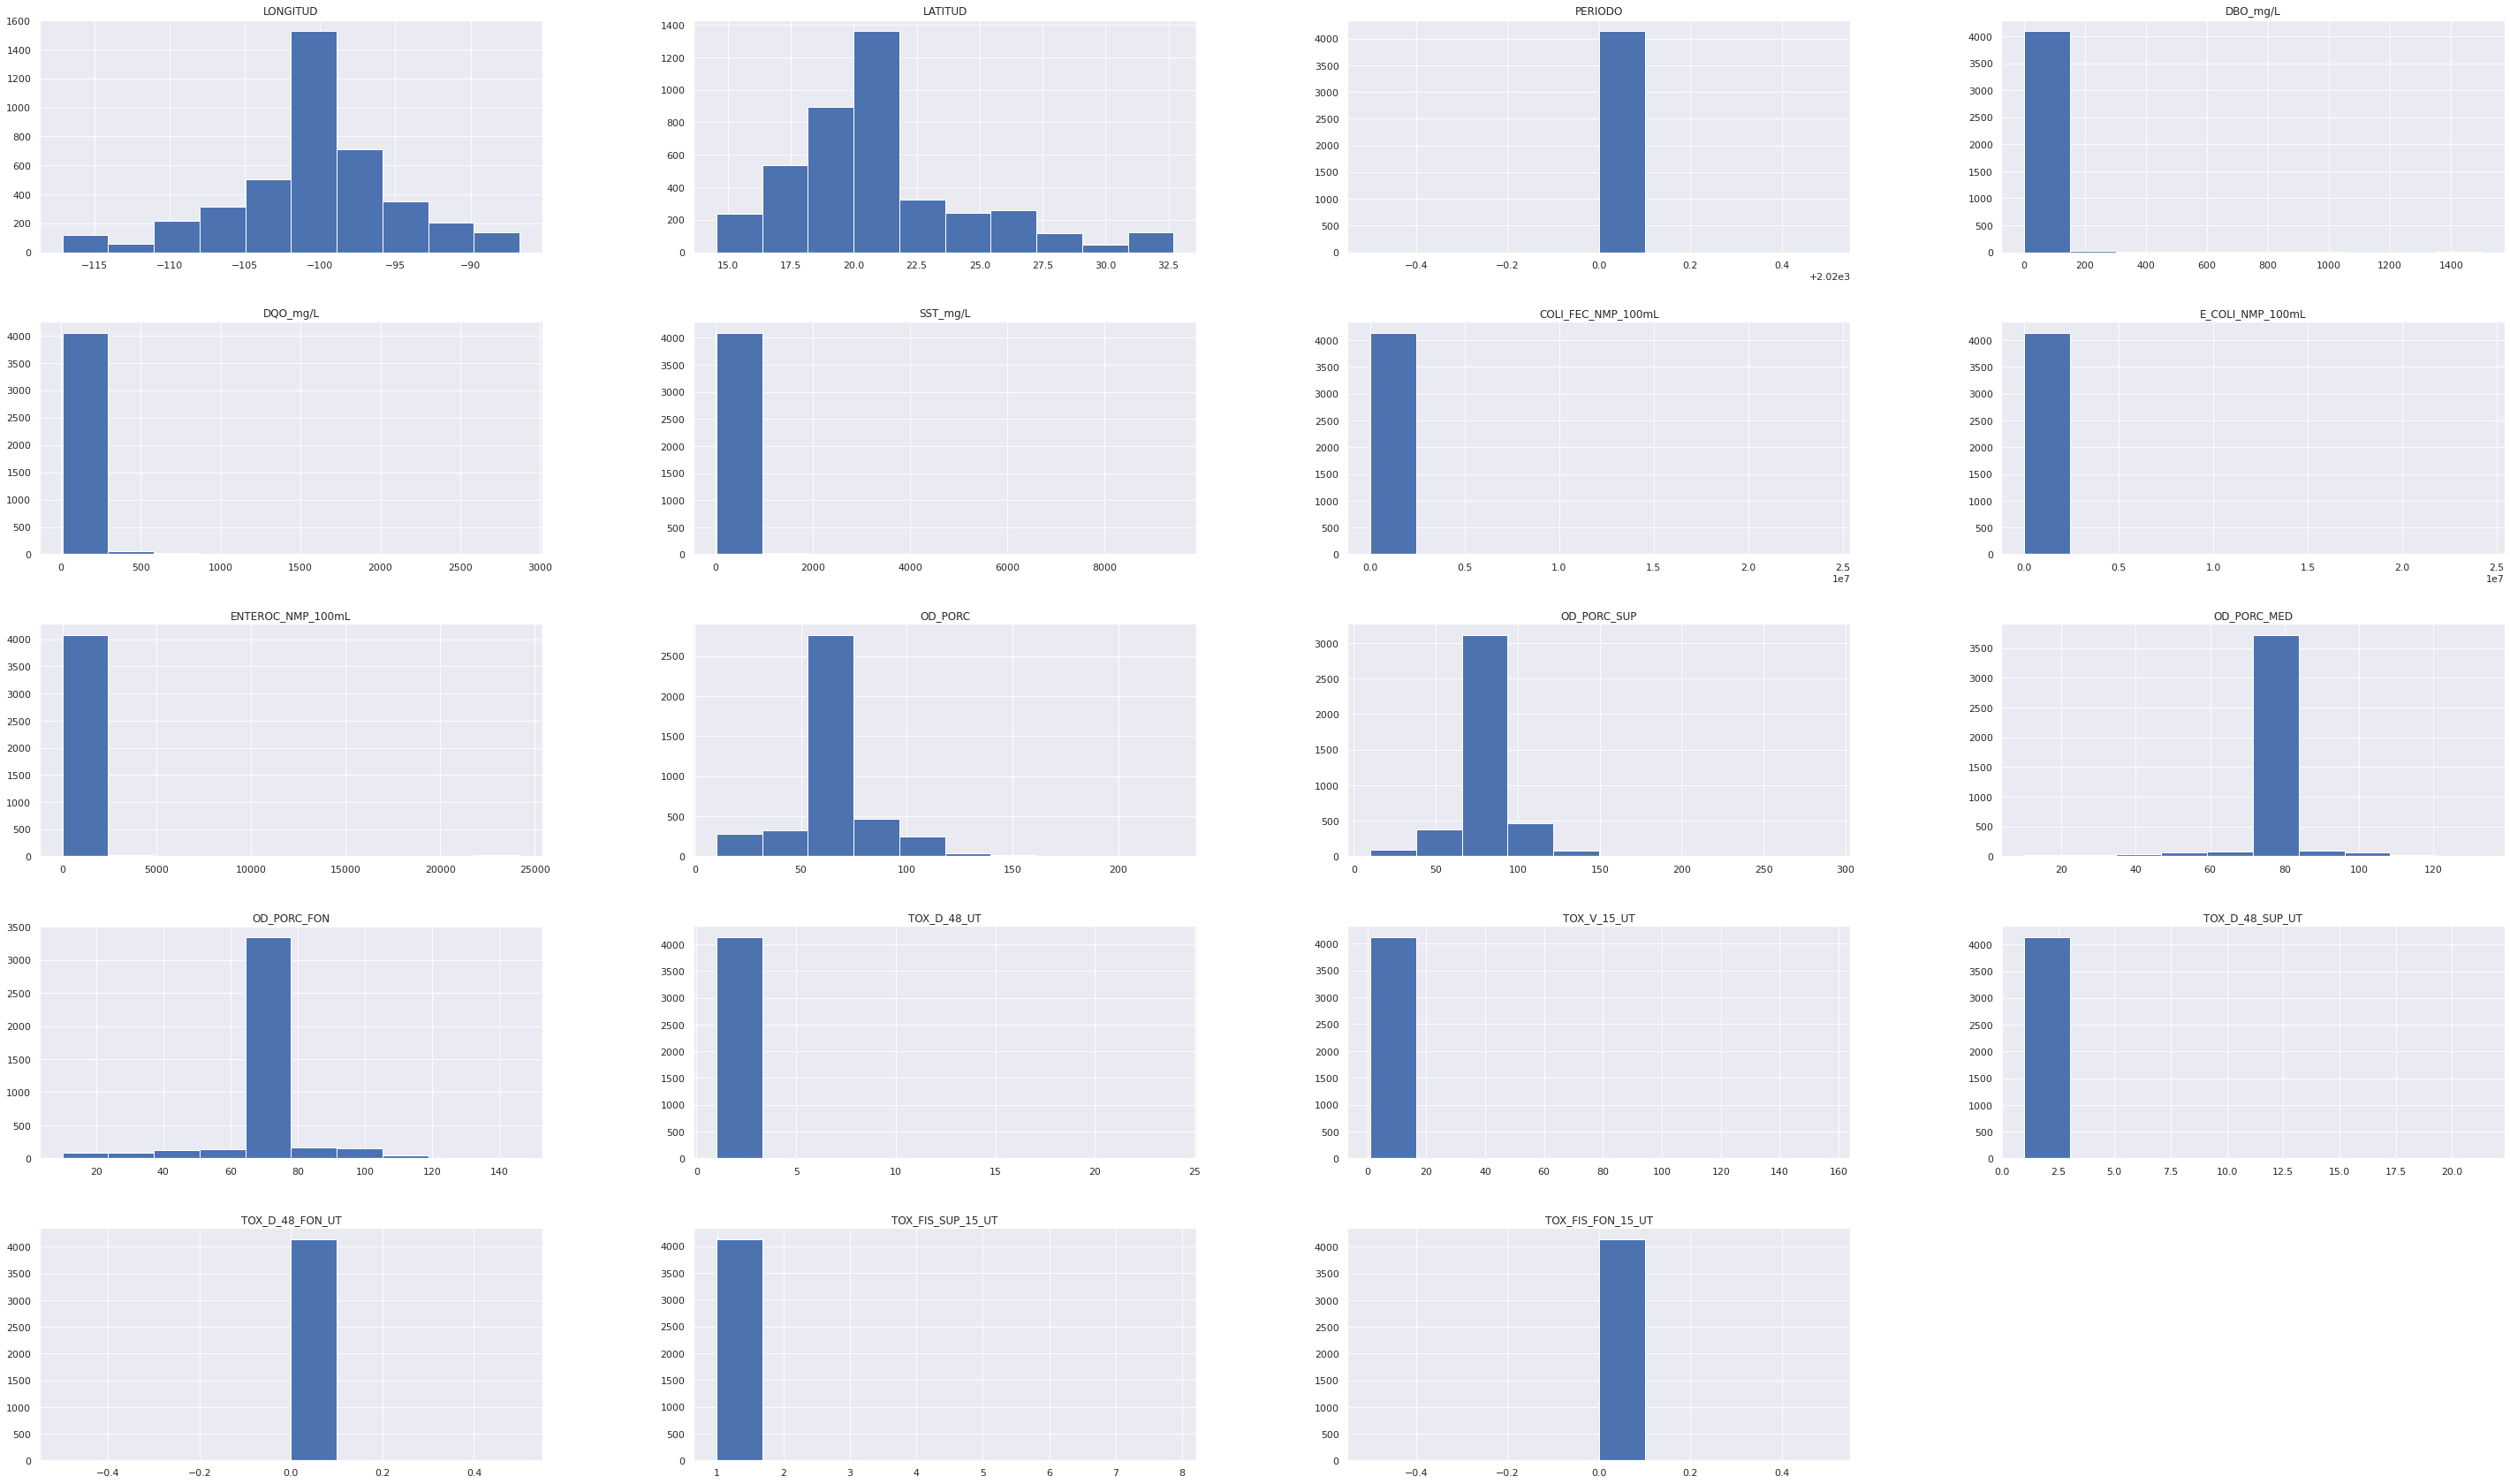

In [ ]:
sns.set(rc={'figure.figsize':(50,30)})

df_numeric = dfsup[quantitative_features2].copy()
df_numeric.hist(bins=10)

plt.show()

---
Como las columnas son diferentes en escala, las vamos a estandarizar para tener una escala común al construir el modelo de aprendizaje automático utilizando **```StandardScaler()```**.

---

In [ ]:
quantitative_transformer2 = Pipeline(
    steps=[("imputer_quantitative", SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]
)

---
Para nuestras variables de tipo categorico aplicaremos la transformación **```OneHotEncoder```** la cual permite que nuestros datos categoricos sean mas expresivos. Debido que muchos modelos de aprendizaje automatico requieren trabajar con datos numericos.

---

In [ ]:
categorical_transformer2 = Pipeline(
    [('imputer_categorical', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown = 'ignore'))]
)

---
Se crea el objeto Pre-procesador (Instancia de ColumnTransformer) que se utilizará más adelante como parte del Pipeline. ColumnTransformer toma una lista, que contiene tuplas de las transformaciones que deseamos realizar en las diferentes columnas. **(Esto será utilizado para la segunda parte del reto)**

---

In [ ]:
preprocessor2 = ColumnTransformer(
        transformers = [
            ('ordinal_transformer2', ordinal_transformer2, ordinal_features2),
            ('quantitative_transformer2', quantitative_transformer2, quantitative_features2),
            ('categorical_transformer2', categorical_transformer2, categorical_features2)
        ],
    remainder='passthrough' #Todas las columnas restantes que no se especificaron transformers se pasarán automáticamente
)

---
## **Ejercicio 2. Exploración de los datos**

---

Primero vamos a observar nuestras métricas estadisticas generales.

---

In [ ]:
dfsup.describe()

,LONGITUD,LATITUD,PERIODO,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_D_48_FON_UT,TOX_FIS_SUP_15_UT,TOX_FIS_FON_15_UT
count,4141.000000,4141.000000,4141.0,4141.000000,4141.000000,4141.000000,4.141000e+03,4.141000e+03,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.000000,4141.0,4141.000000,4141.0
mean,-100.271643,20.906467,2020.0,11.512815,50.271298,89.888837,6.056752e+04,4.962833e+04,239.570077,67.666288,83.067798,72.304820,67.355820,1.017234,1.339866,1.000113,0.0,1.000104,0.0
std,5.626960,3.590868,0.0,51.885815,119.653167,406.567423,9.240315e+05,8.309882e+05,2060.225622,20.706213,17.902485,9.039026,13.474598,0.433631,4.211948,0.372831,0.0,0.204176,0.0
min,-117.124030,14.534910,2020.0,1.990000,9.990000,9.990000,2.990000e+00,2.990000e+00,2.990000,9.990000,9.990000,9.990000,9.990000,0.990000,0.990000,0.990000,0.0,0.990000,0.0
25%,-103.009250,18.789040,2020.0,1.990000,20.700000,12.000000,1.333000e+03,1.500000e+02,2.990000,68.300000,84.100000,72.400000,67.500000,0.990000,0.990000,0.990000,0.0,0.990000,0.0
50%,-99.795530,20.148980,2020.0,2.630000,27.010000,24.300000,2.400000e+03,4.240000e+02,2.990000,68.300000,84.100000,72.400000,67.500000,0.990000,0.990000,0.990000,0.0,0.990000,0.0
75%,-97.680560,21.998090,2020.0,5.000000,35.750000,48.000000,4.600000e+03,1.100000e+03,2.990000,68.300000,84.100000,72.400000,67.500000,0.990000,0.990000,0.990000,0.0,0.990000,0.0
max,-86.732150,32.706500,2020.0,1500.000000,2871.250000,9430.000000,2.419600e+07,2.419600e+07,24196.000000,226.100000,289.000000,133.000000,146.000000,23.949000,156.250000,21.320000,0.0,7.870000,0.0


---
Ahora observaremos la correlación entre nuestras variables.

---

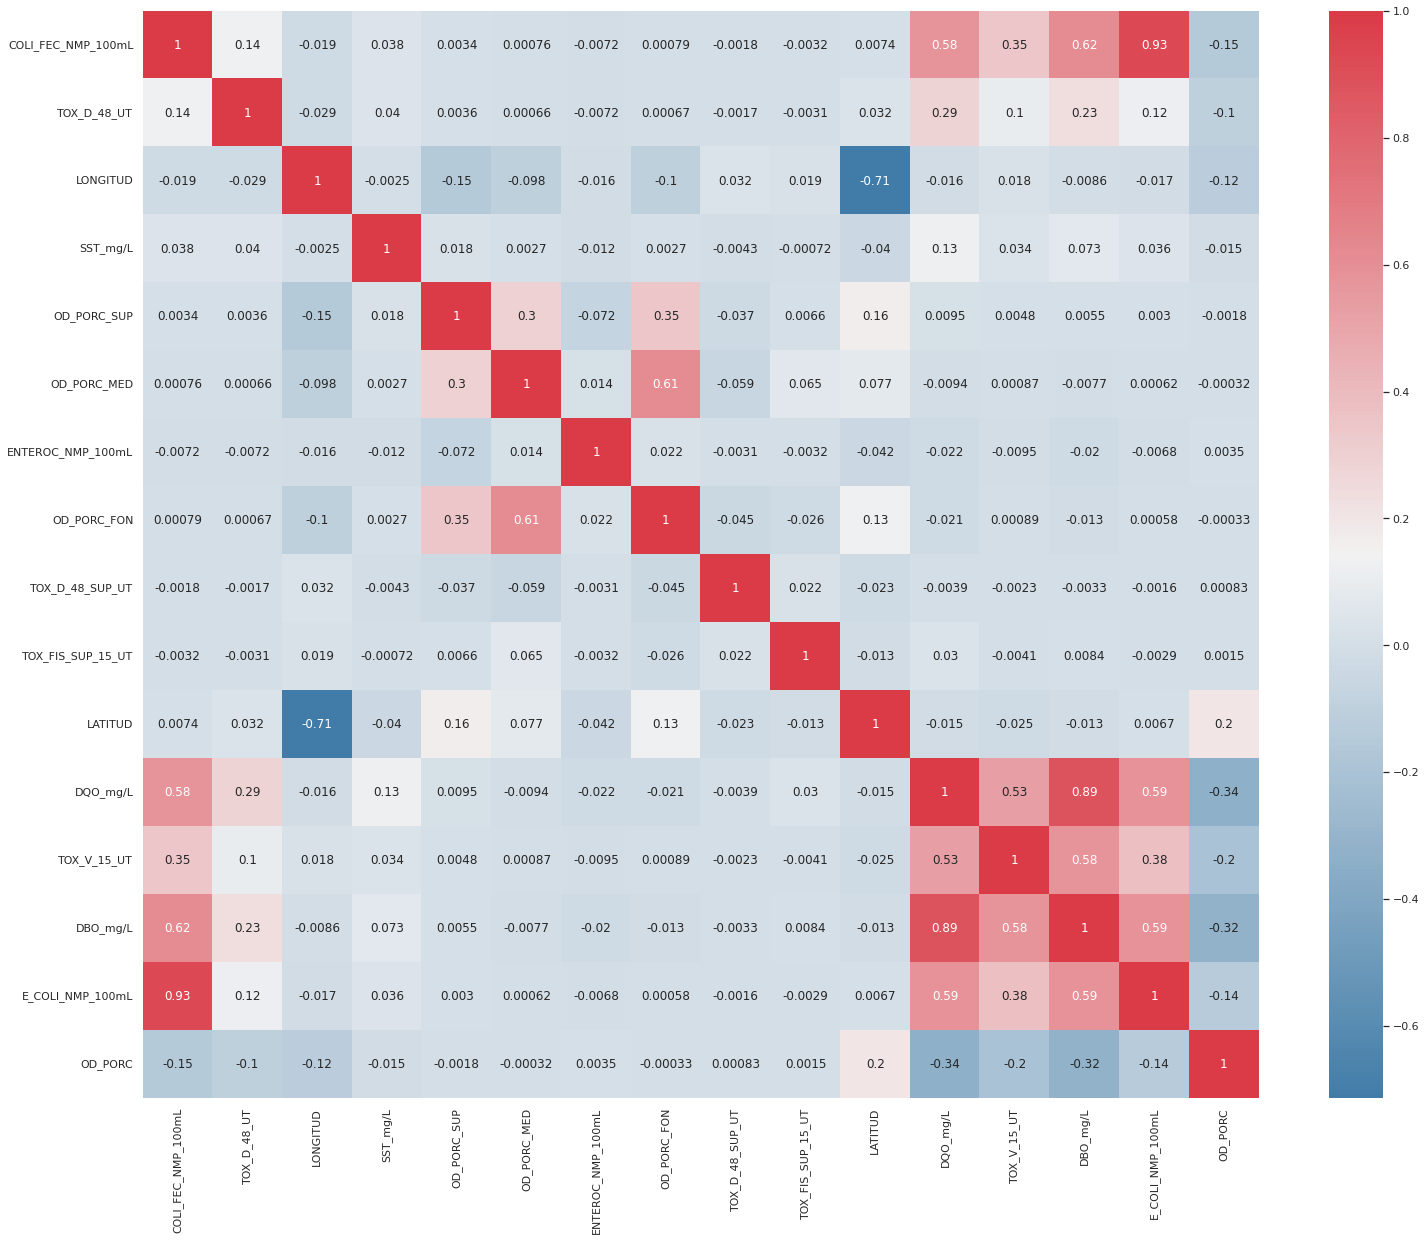

In [ ]:
featureLabels2={'CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO',
       'CUENCA', 'CUERPO DE AGUA', 'TIPO', 'SUBTIPO', 'LONGITUD', 'LATITUD',
       'DBO_mg/L', 'CALIDAD_DBO', 'DQO_mg/L', 'CALIDAD_DQO',
       'SST_mg/L', 'CALIDAD_SST', 'COLI_FEC_NMP_100mL', 'CALIDAD_COLI_FEC',
       'E_COLI_NMP_100mL', 'CALIDAD_E_COLI', 'ENTEROC_NMP_100mL',
       'CALIDAD_ENTEROC', 'OD_PORC', 'CALIDAD_OD_PORC', 'OD_PORC_SUP',
       'CALIDAD_OD_PORC_SUP', 'OD_PORC_MED', 'CALIDAD_OD_PORC_MED',
       'OD_PORC_FON', 'CALIDAD_OD_PORC_FON', 'TOX_D_48_UT', 'CALIDAD_TOX_D_48',
       'TOX_V_15_UT', 'CALIDAD_TOX_V_15', 'TOX_D_48_SUP_UT',
       'CALIDAD TOX_D_48_SUP', 'CALIDAD_TOX_D_48_FON',
       'TOX_FIS_SUP_15_UT', 'CALIDAD_TOX_FIS_SUP_15',
       'CALIDAD_TOX_FIS_FON_15','CUMPLE_CON_DBO',
       'CUMPLE_CON_DQO', 'CUMPLE_CON_SST', 'CUMPLE_CON_CF',
       'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC', 'CUMPLE_CON_OD',
       'CUMPLE_CON_TOX', 'GRUPO'}
yValue2=pd.Series(dfsup.loc[:,"SEMAFORO"])
dfsupFeatures2=pd.DataFrame(dfsup,columns=featureLabels2)  
xValue2=pd.DataFrame(dfsub,columns=quantitative_features2) 
fig = plt.figure(figsize=(25, 20))

sns.heatmap(dfsupFeatures2.corr(), annot=True,cmap=sns.diverging_palette(240, 10, n=9,as_cmap=True))

---
Encontramos las siguientes correlaciones fuertes:

* E_COLI_NMP_100mL - COLI_FEC_NMP_100mL = 0.93
* DQO_mg/L - DBO_mg/L = 0.89
* OD_PORC_MED - OD_PORC_FON = 0.61
* E_COLI_NMP_100mL - DBO_mg/L = 0.59
* COLI_FEC_NMP_100mL - DQO_mg/L = 0.58
* TOX_V_15_UT - DBO_mg/L = 0.58
* TOX_V_15_UT - DQO_mg/L = 0.53 

Correlaciones moderadas: 

* TOX_V_15_UT - E_COLI_NMP_100mL = 0.38
* COLI_FEC_NMP_100mL - TOX_V_15_UT  = 0.35
* OD_PORC_MED - OD_PORC_SUP = 0.3
* DQO_mg/L - TOX_D_48_UT = 0.29
* TOX_D_48_UT - DBO_mg/L = 0.23


Por otro lado, observemos los valores atípicos.

---

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


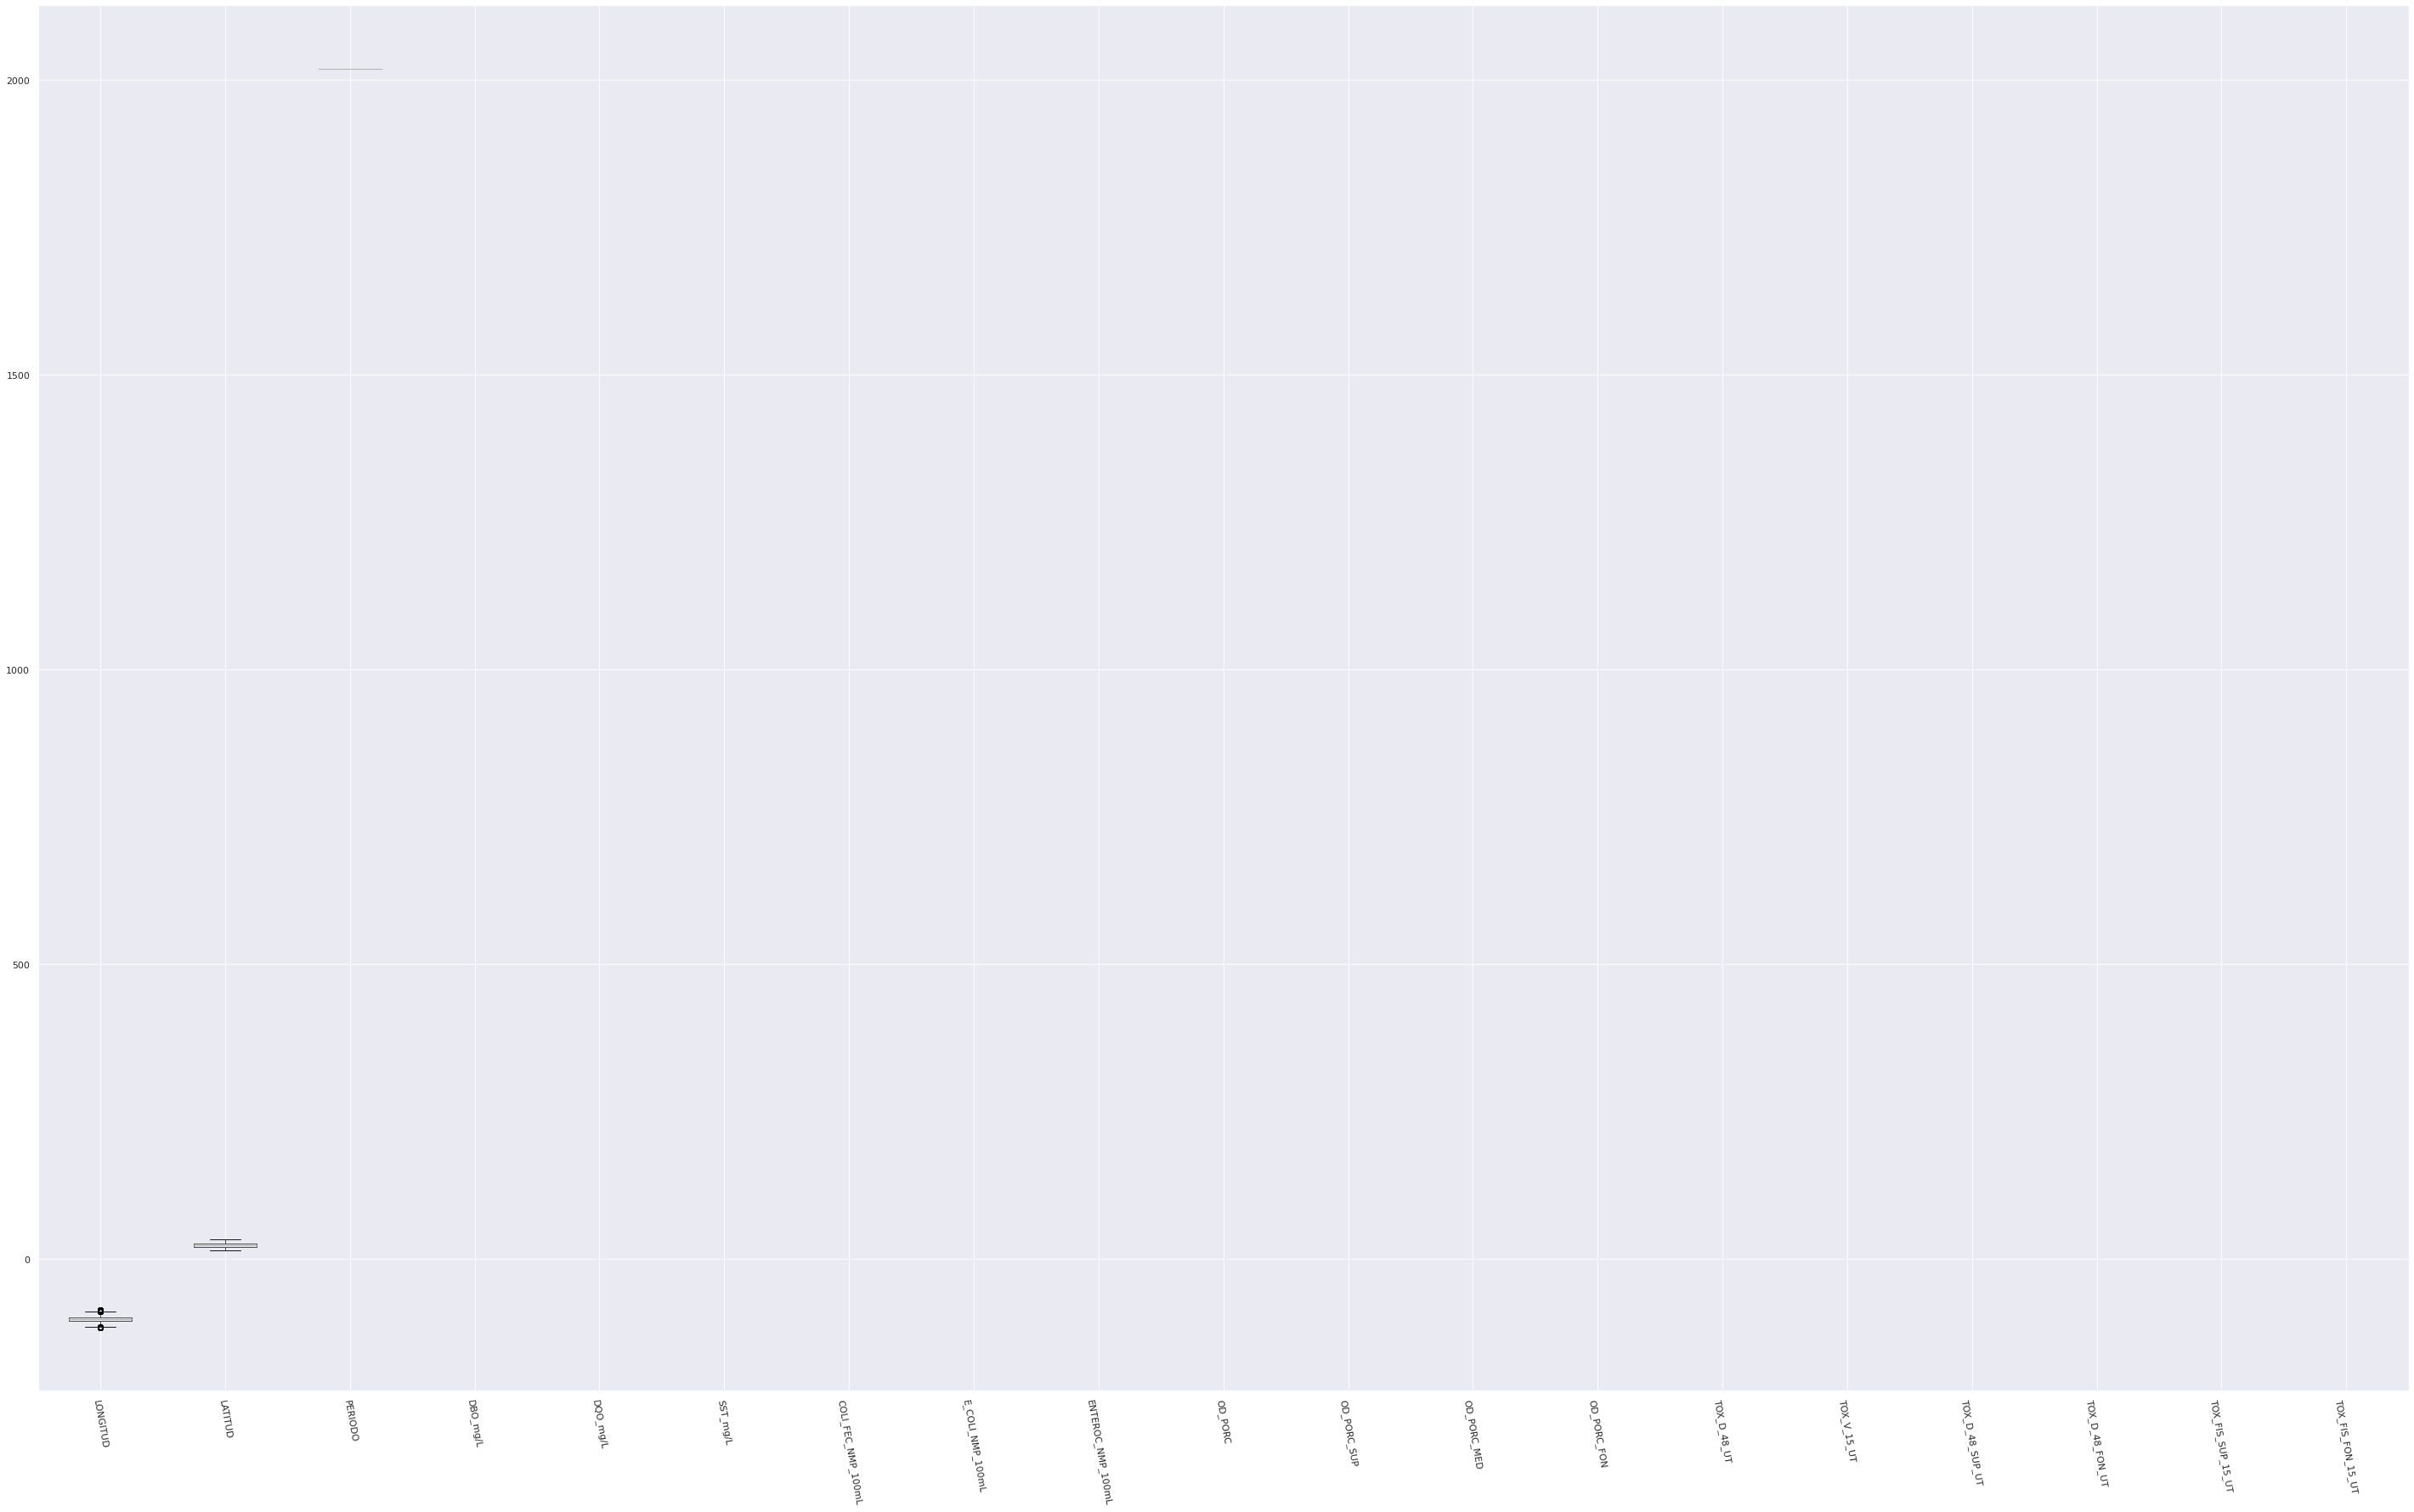

In [ ]:
xValue2.boxplot(rot=1000)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


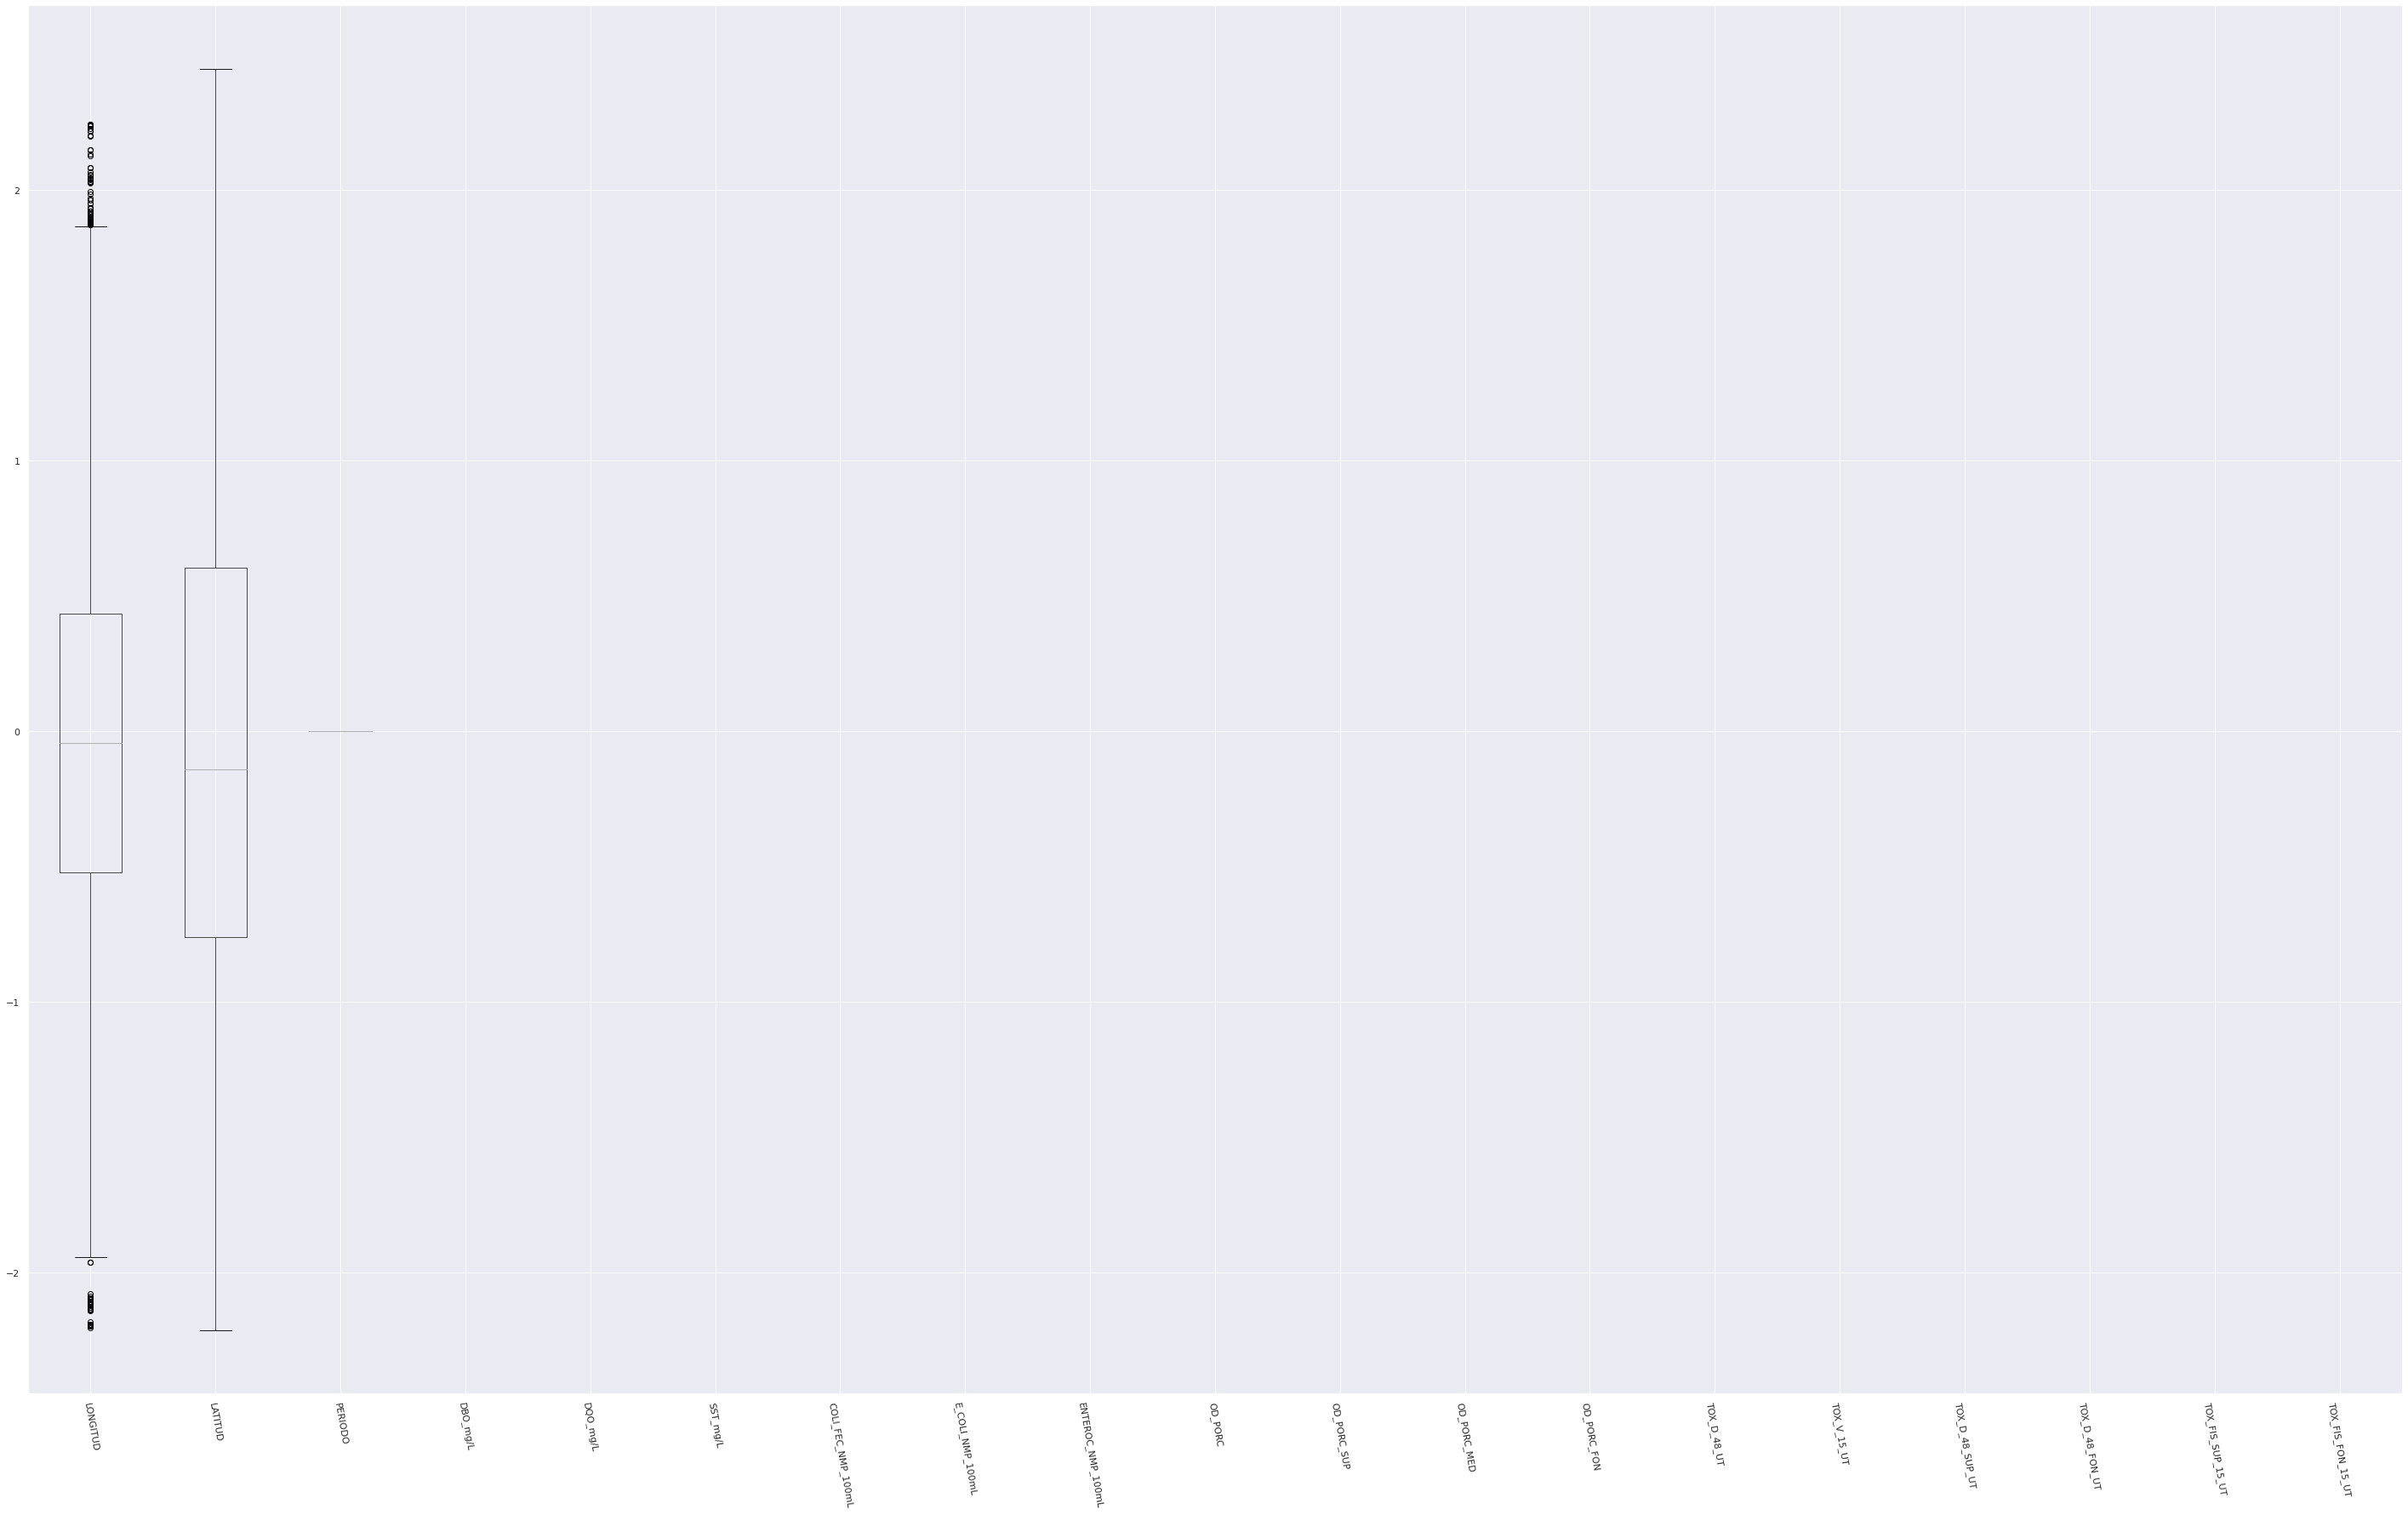

In [ ]:
from sklearn.preprocessing import StandardScaler #Normalizando estos valores, para observarlos mejor
import numpy as np
sc = StandardScaler()
X_scaled2 = sc.fit_transform(xValue2)
pd.DataFrame(X_scaled2,columns=quantitative_features2).boxplot(rot=1000)

---
Observamos nuestra variable de salida

---

In [ ]:
yValue2

0           Rojo
1          Verde
2          Verde
3          Verde
4          Verde
5          Verde
6          Verde
7           Rojo
8       Amarillo
9       Amarillo
10      Amarillo
11      Amarillo
12         Verde
13      Amarillo
14         Verde
15         Verde
16         Verde
17         Verde
18      Amarillo
19         Verde
20         Verde
21         Verde
22         Verde
23         Verde
24         Verde
25         Verde
26         Verde
27         Verde
28         Verde
29         Verde
30         Verde
31         Verde
32      Amarillo
33      Amarillo
34         Verde
35          Rojo
36         Verde
37         Verde
38         Verde
39         Verde
40         Verde
41         Verde
42         Verde
43         Verde
44         Verde
45         Verde
46         Verde
47         Verde
48         Verde
49         Verde
50         Verde
51         Verde
52         Verde
53         Verde
54      Amarillo
55      Amarillo
56      Amarillo
57      Amarillo
58          Ro

---
Observaremos nuestra varianza acomulada.

---

Eigenvalues:
[2.62529115e+00 2.09165802e+00 1.92220844e+00 1.42153306e+00
 1.03173192e+00 1.00586195e+00 9.90582907e-01 9.65183848e-01
 8.99230819e-01 8.60098841e-01 6.82756903e-01 5.56565251e-01
 3.62528898e-01 2.90668894e-01 2.12865200e-01 9.62292042e-02
 7.67303448e-33 4.10443784e-33]

Variances (Percentage):
[1.63927063e+01 1.30606221e+01 1.20025539e+01 8.87626272e+00
 6.44228677e+00 6.28075083e+00 6.18534622e+00 6.02675073e+00
 5.61493026e+00 5.37058440e+00 4.26323511e+00 3.47527576e+00
 2.26368407e+00 1.81497958e+00 1.32916180e+00 6.00869387e-01
 4.79115624e-32 2.56287171e-32]



Text(0, 0.5, 'Explained variance (%)')

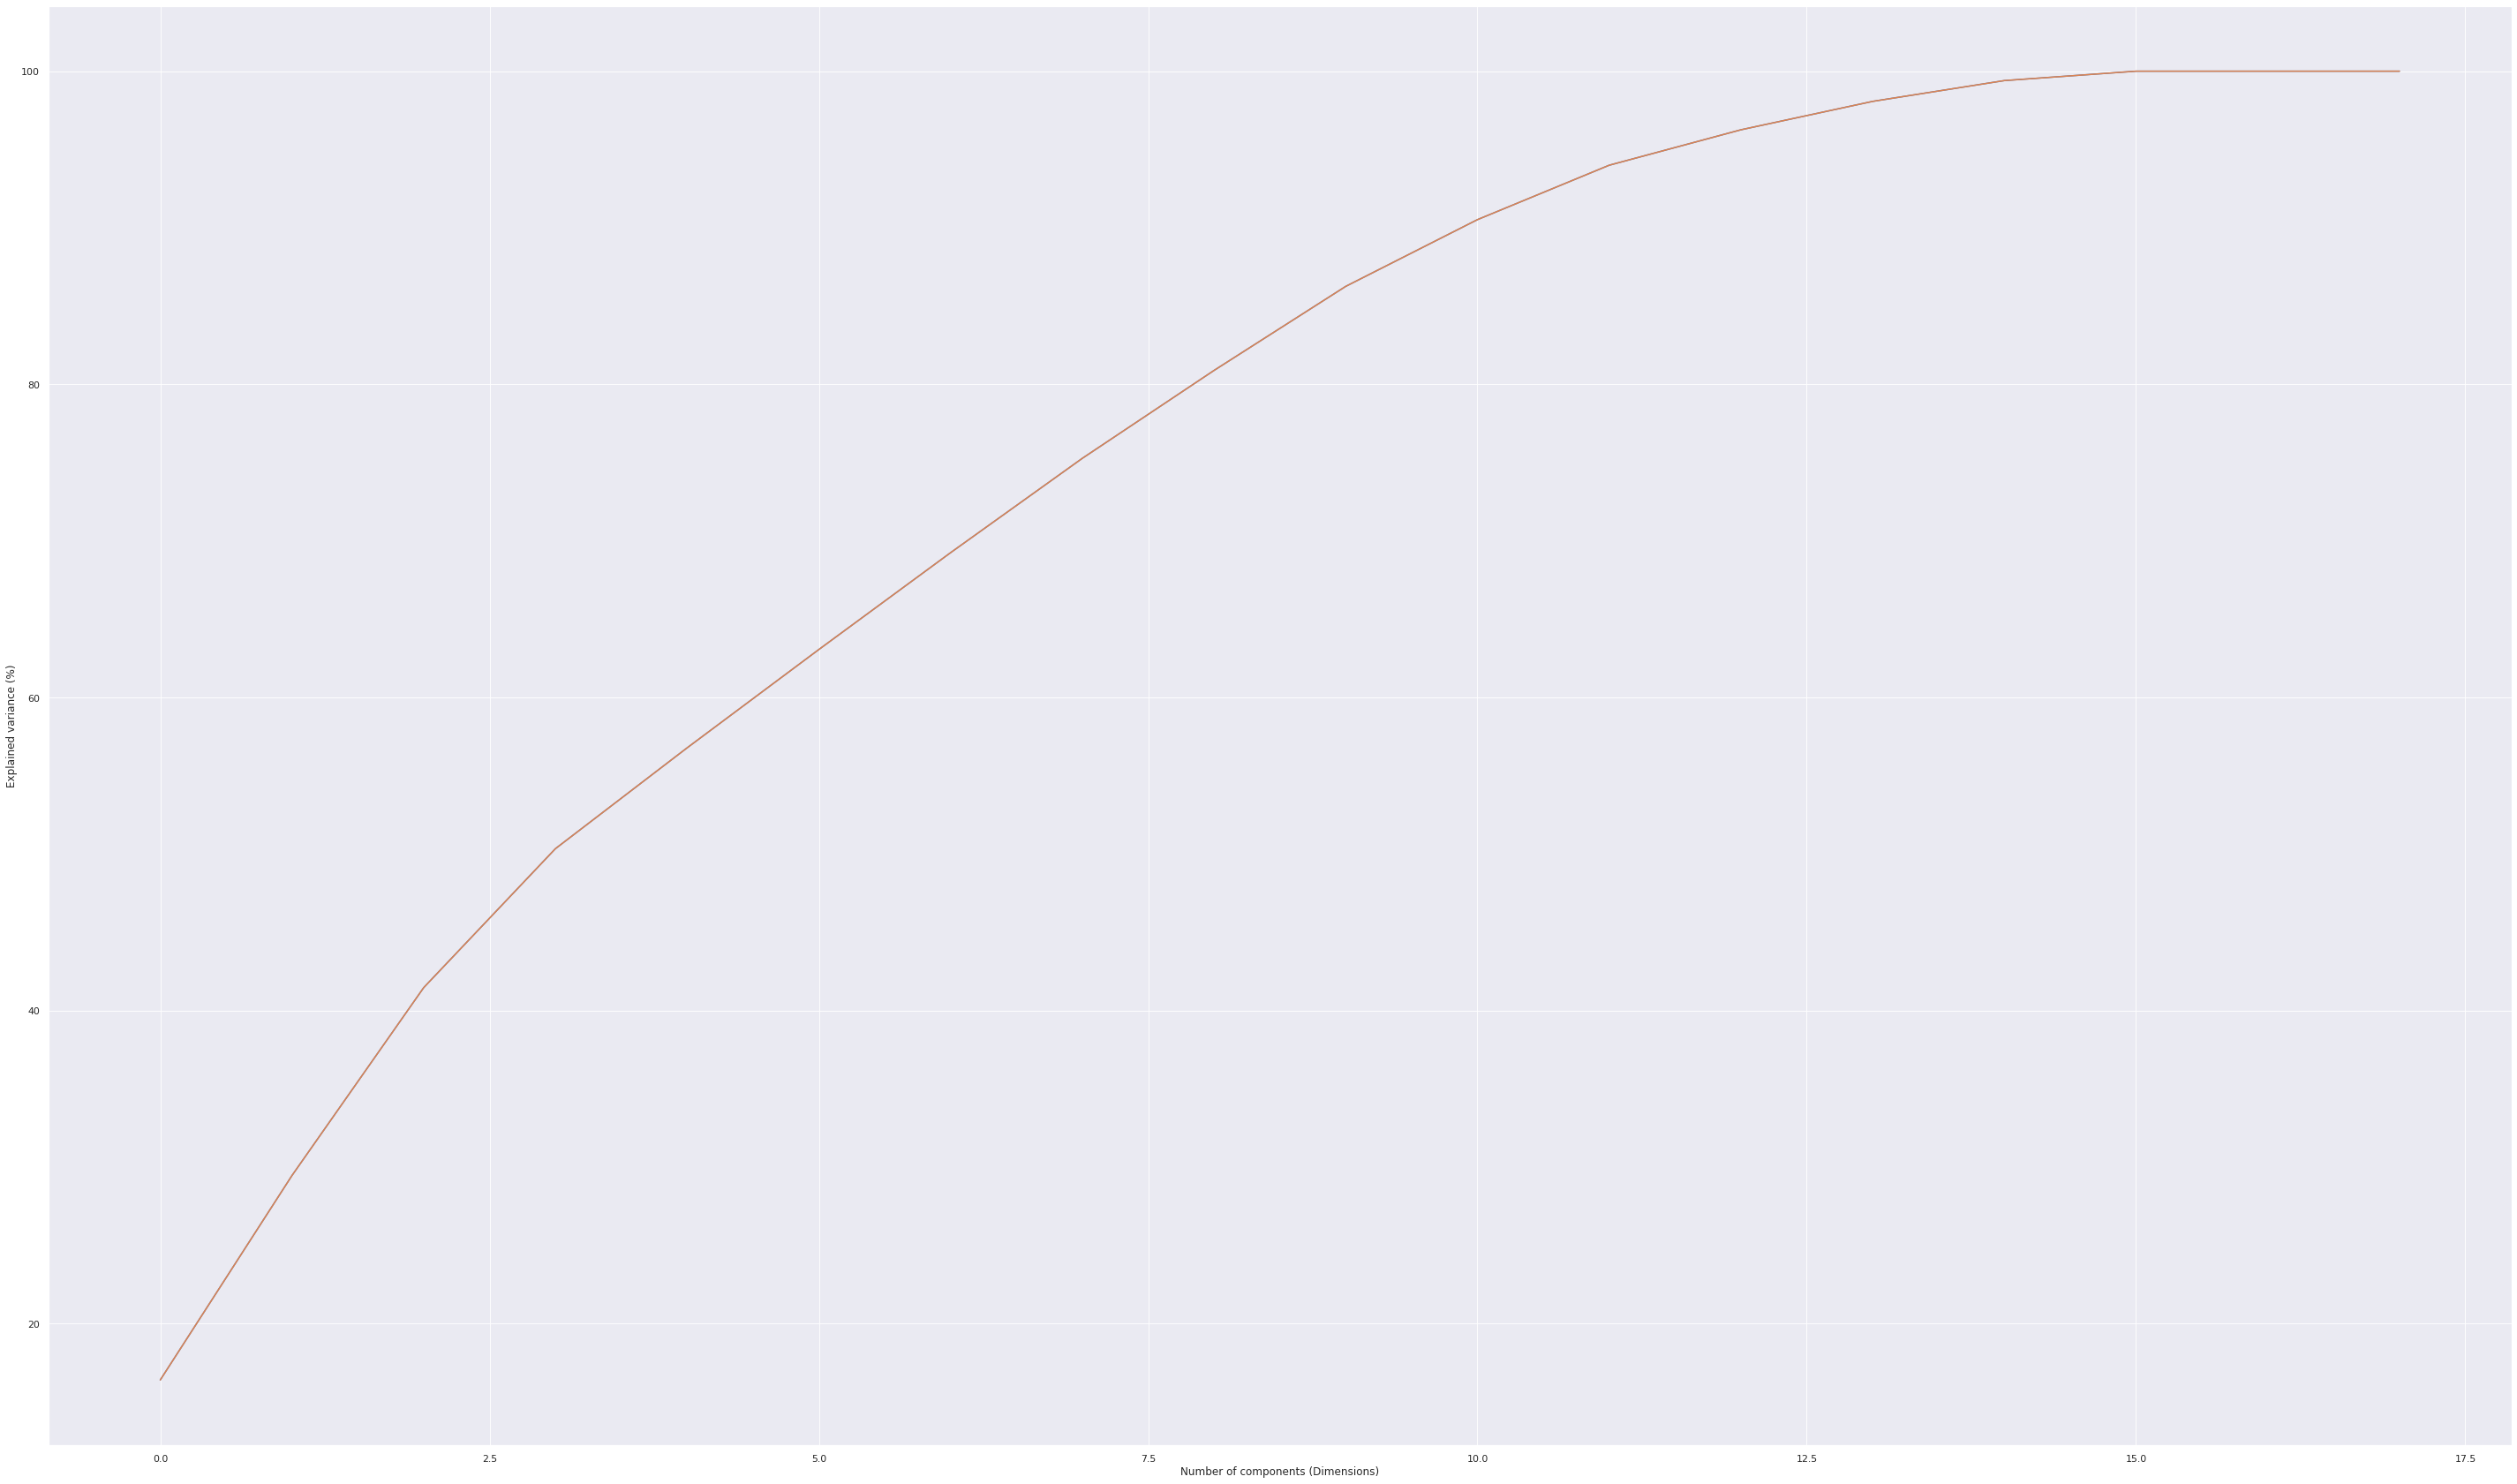

In [ ]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler
import numpy as np

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
pca.fit(X_scaled)

# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

---
Para el caso de la desviación estandar los valores estan muy cercanos a 0.

---

---
## **Ejercicio 3. Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.**

---

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
latlong2=dfsup[["LATITUD","LONGITUD"]] 

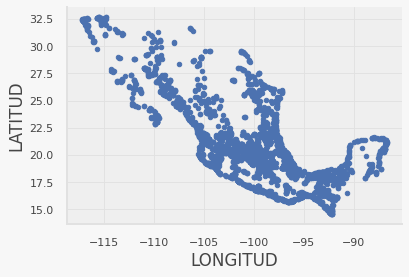

In [ ]:
latlong2.plot.scatter("LONGITUD","LATITUD")

---
Para tener una mejor comprensión, observaremos nuestras métricas estadisticas.

---

In [ ]:
latlong2.describe()

,LATITUD,LONGITUD
count,4141.000000,4141.000000
mean,20.906467,-100.271643
std,3.590868,5.626960
min,14.534910,-117.124030
25%,18.789040,-103.009250
50%,20.148980,-99.795530
75%,21.998090,-97.680560
max,32.706500,-86.732150


--- 
En nuestro DF agregaremos una nueva columna para tener el punto, que nos permita graficar apropiadamente en el mapa.

---

In [ ]:
dfsup["Coordenadas"] = list(zip(dfsup.LONGITUD, dfsup.LATITUD))
dfsup["Coordenadas"] = dfsup["Coordenadas"].apply(Point)
dfsup['color'] = dfsup['SEMAFORO'].replace({'Verde':'green','Amarillo':'yellow','Rojo':'red'}, inplace = True)

In [ ]:
gdf = gpd.GeoDataFrame(dfsup, geometry="Coordenadas")
gdf.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO,Coordenadas,color
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020,6.00,Buena calidad,54.08,Contaminada,13.7500,Excelente,1162.0,Contaminada,98.0,Excelente,2.99,Excelente,68.3,Excelente,46.8,Aceptable,72.4,Excelente,67.5,Fuertemente contaminada,0.99,No Toxico,0.99,No Toxico,0.99,No Toxico,0.0,vacio,0.99,No Toxico,0.0,vacio,red,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO,POINT (-102.33911 22.24730),None
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020,2.63,Excelente,27.01,Contaminada,9.9900,Excelente,2400.0,Fuertemente contaminada,424.0,Fuertemente contaminada,20.00,Excelente,68.3,Excelente,92.0,Excelente,95.4,Excelente,92.2,Excelente,0.99,No Toxico,0.99,No Toxico,0.99,No Toxico,0.0,vacio,0.99,No Toxico,0.0,vacio,green,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO,POINT (-109.84290 22.90473),None
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,22.89880,2020,2.63,Excelente,27.01,Contaminada,9.9900,Excelente,2400.0,Fuertemente contaminada,424.0,Fuertemente contaminada,2.99,Excelente,68.3,Excelente,92.0,Excelente,95.4,Excelente,92.2,Excelente,0.99,No Toxico,0.99,No Toxico,0.99,No Toxico,0.0,vacio,0.99,No Toxico,0.0,vacio,green,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO,POINT (-109.86442 22.89880),None
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,22.89609,2020,2.63,Excelente,27.01,Contaminada,13.9667,Excelente,2400.0,Fuertemente contaminada,424.0,Fuertemente contaminada,2.99,Excelente,68.3,Excelente,84.1,Excelente,72.4,Excelente,86.7,Excelente,0.99,No Toxico,0.99,No Toxico,0.99,No Toxico,0.0,vacio,0.99,No Toxico,0.0,vacio,green,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO,POINT (-109.88604 22.89609),None
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,22.87694,2020,2.63,Excelente,27.01,Contaminada,9.9900,Excelente,2400.0,Fuertemente contaminada,424.0,Fuertemente contaminada,30.00,Excelente,68.3,Excelente,96.2,Excelente,95.9,Excelente,95.5,Excelente,0.99,No Toxico,0.99,No Toxico,0.99,No Toxico,0.0,vacio,0.99,No Toxico,0.0,vacio,green,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO,POINT (-109.89657 22.87694),None


In [ ]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [ ]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

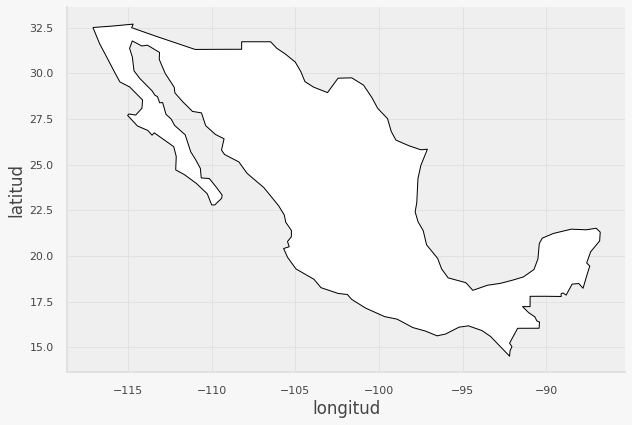

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

# Vamos a graficar solamente Mexico
world.query("name == 'Mexico'").plot(ax=gax, edgecolor='black',color='white')
gax.set_xlabel('longitud')
gax.set_ylabel('latitud')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

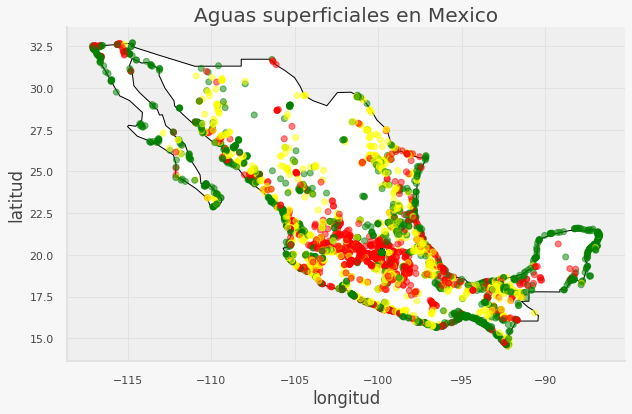

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))


world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

gdf.plot(ax=gax, color=dfsup['SEMAFORO'], alpha = 0.5)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Aguas superficiales en Mexico')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

---
Teniendo en cuenta las practicas anteriores, utilizaremos el metodo del codo el cual nos permite producir una función de costo para encontrar relaciones.

---

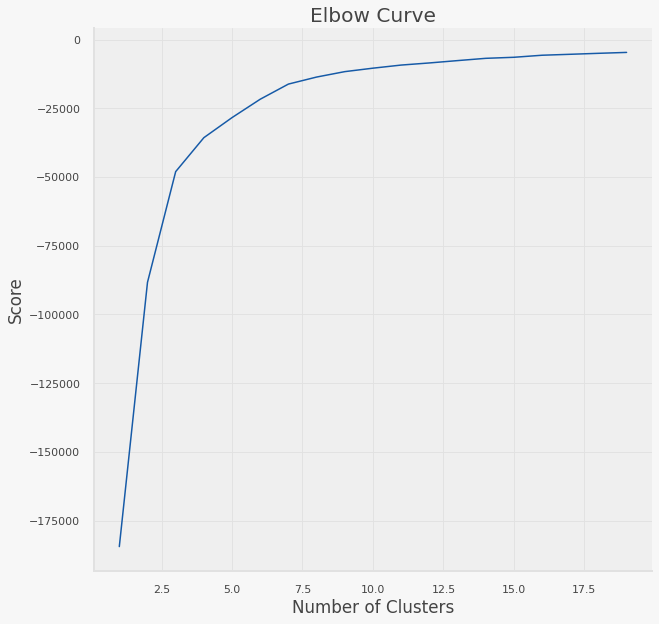

In [ ]:
#Para este paso importaremos la libreria de sklearn cluster para trabajar con kmeans
from sklearn.cluster import KMeans
X = dfsup[["LONGITUD","LATITUD"]]

#De esta manera definiremos nuestra elbow curve para determinar la cantidad optima de clusters que vamos a requerir.
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.subplots(figsize=(10,10))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
#Ahora vamos a poder elegir los 5 clusters que nos daran las coordenadas donde más fuentes de agua subterraneas tenemos
kmeans = KMeans(n_clusters=5).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X)
C = kmeans.cluster_centers_

C_DF = pd.DataFrame(C)
C_DF["Coordenadas"] = list(zip(C_DF[0], C_DF[1]))
C_DF["Coordenadas"] = C_DF["Coordenadas"].apply(Point)


gdf_C = gpd.GeoDataFrame(C_DF, geometry="Coordenadas")
gdf_C

,0,1,Coordenadas
0,-99.235210,24.909708,POINT (-99.23521 24.90971)
1,-104.530186,21.589712,POINT (-104.53019 21.58971)
2,-99.318230,19.450955,POINT (-99.31823 19.45095)
3,-92.207295,17.785082,POINT (-92.20730 17.78508)
4,-111.644977,28.539342,POINT (-111.64498 28.53934)


---
Graficaremos de nuevo nuestro mapa para ver donde estan los puntos que mas fuentes de agua subterranea tienen.

---

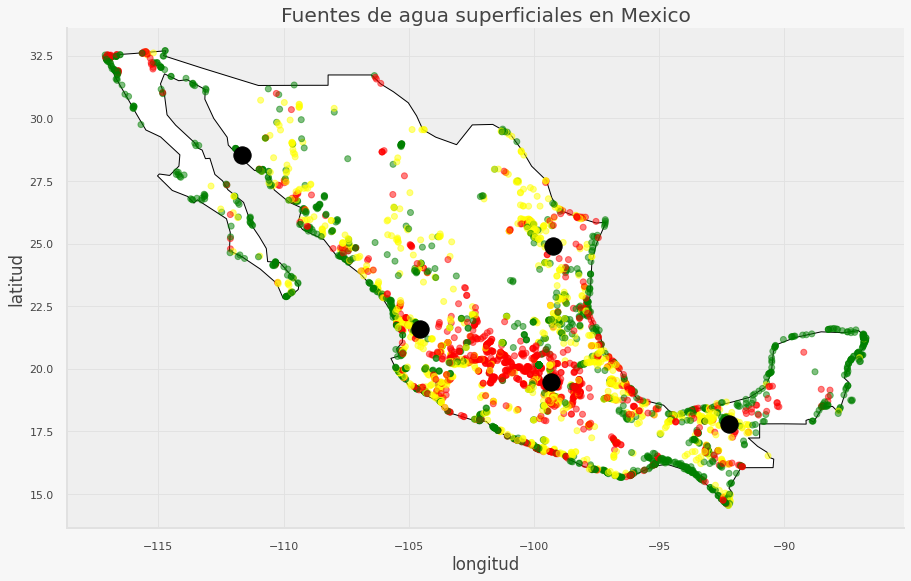

In [ ]:
fig, gax = plt.subplots(figsize=(15,10))
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')


gdf.plot(ax=gax, color=dfsup['SEMAFORO'], alpha = 0.5)
gdf_C.plot(ax=gax, color='black', alpha = 1, markersize = 300)

gax.set_xlabel('longitud')
gax.set_ylabel('latitud')
gax.set_title('Fuentes de agua superficiales en Mexico')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [ ]:
#Realizaremos el conteo de fuentes de agua subterranea por cluster
latlong2['kmeans'] = kmeans.labels_
latlong2.loc[:, 'kmeans'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    1966
1     763
3     713
2     409
4     290
Name: kmeans, dtype: int64

In [ ]:
#Si recordamos las coordenadas que obtuvimos arriba, vamos a determinar en donde se encuentran exactamente, para lo cual es importante realizar una concatenación de la latitud y longitud.
from pandas.core.internals.concat import concat_arrays

print(gdf_C[0][0])
print(gdf_C[1][0])

Location1 = str(gdf_C[1][0]) + ", " + str(gdf_C[0][0])
print(Location1)
Location2 = str(gdf_C[1][1]) + ", " + str(gdf_C[0][1])
print(Location2)
Location3 = str(gdf_C[1][2]) + ", " + str(gdf_C[0][2])
print(Location3)
Location4 = str(gdf_C[1][3]) + ", " + str(gdf_C[0][3])
print(Location4)
Location5 = str(gdf_C[1][4]) + ", " + str(gdf_C[0][4])
print(Location5)

-99.28616923625255
19.525308701629324
19.525308701629324, -99.28616923625255
21.581717019607844, -104.52934779084967
28.536860244498776, -111.66155207823962
17.7850816970547, -92.20729510518933
25.39179855172414, -99.47762479310344


In [ ]:
#posteriormente, mediante la libreria geopy podemos tomar estos datos concatenados y observar la ubicación exacta de los lugares
from geopy.geocoders.yandex import Location
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="my-application")
Locations = [Location1, Location2, Location3, Location4, Location5]
for i in Locations:
  location = geolocator.reverse(i)

  print(location.address)

locations1 = geolocator.reverse(Location1)
locations2 = geolocator.reverse(Location2)

Naucalpan, Naucalpan de Juárez, Estado de México, 53126, México
Paso de Álica, Del Nayar, Nayarit, México
Hermosillo, Sonora, México
Corralillo Segunda Sección (La Princesa), Macuspana, Tabasco, México
Carretera China-Montemorelos, Las Anacuas, General Terán, Nuevo León, México


### **Comentarios Finales**

---
* De acuerdo a este analisis observamos que en las zonas de Naucalpan, Paso de Álica, Hermosillo, Corralillo y Carretera China-Montemorelos, presentan puntos con algunos niveles de agua criticos particularmente en la zona del DF lo cual es de entenderse ya que por la cantidad de personas y el movimiento diario se produce más contaminación, caso opuesto a algunas zonas costeras o no tan pobladas que logramos encontrar buenos resultados en cuanto la calidad del agua. 

---